# Household Pulse Data Analysis

This analysis examines Long Covid (L.C.) prevalence across U.S. states and the District of Columbia, based on data from the U.S. Centers for Disease Control and Prevention (CDC) as of February 2024. We will explore potential predictors of L.C. rates and investigate statistical relationships between these factors. The dataset was curated by Julia Moore Vogel, and this analysis was conducted by Ashley Yaner. As advised by Julia Vogel, Baysian Variable selection, a statistical method used to identify the most relevant predictors or variables in a dataset, will be used to understand the most prevelant factors contributing to the rates of COVID per state. ---> Wordage similar to Bobby's

# Imports

In [1]:
# !pip install --upgrade arviz

In [1]:
from utils.prepare_data import *
from utils.math import *
from utils.plots import *
from utils.data_exploration import *
from model.model_bvs import *
from model.inspect_results_bvs import *

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import pandas as pd
# Set options for displaying all columns and rows in dataframe for later inspection
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None) 

In [3]:
# Check pymc version for environmental package consistancy
# pm.__version__

# Configs

Path to the household pulse data csv

In [4]:
# houshold_pulse_path = "LC_household_pulse_for_BV_10.csv"
houshold_pulse_path = "data/LC_household_pulse_v11.csv"

# Load Data

Import the houshold pulse data using pandas dataframe. 

In [5]:
df = load_data(houshold_pulse_path)

# Inspect Raw Data

Inspect household pulse data dataframe. What does it contain?

In [6]:
df.head(10)

,State,Sept 24 Value,Sept 24 Low CI,Sept 24 High CI,Urban,Rural,Conservative,Moderate,Liberal,Political Don't know,Political sum,Below Poverty Line,White,Black,AI_AN,Asian,NHPI,Hispanic,Multiple,Percent of total pop with at least one dose,Percent of pop with an updated (bivalent) booster dose,Percent of 5+ pop with a completed primary series,Percent of 12+ pop with at least one dose,Percent of 18+ pop with a completed primary series,Percent of 65+ pop with a completed primary series,Paid sick leave,Medicaid expansion,Eviction moratoria duration,7/11/2022,8/8/2022,9/26/2022,10/17/2022,11/14/2022,12/19/2022,1/16/2023,2/13/2023,3/13/2023,4/10/2023,5/8/2023,6/19/2023,7/10/2023,8/7/2023,9/4/2023,10/2/2023,10/30/2023,2/5/2024,3/4/2024,4/1/2024,4/29/2024,5/27/2024,6/24/2024,7/22/2024,8/19/2024,9/16/2024,Avg,std_error,count
0,Alabama,7.0,4.8,9.6,57.7,42.3,50.0,29.0,12.0,8.0,99.0,16.5,0.647117,0.264309,0.005532,0.015477,0.000526,0.041489,0.025550,65.1,7.7,56.6,74.2,63.3,85.3,0.0,1.0,59.0,9.0,11.2,7.6,8.0,9.0,6.8,7.3,5.7,7.6,7.3,5.5,7.7,6.7,7.1,6.3,8.8,6.8,7.9,8.3,7.4,8.3,8.6,5.0,5.5,7.6,7.0,7.462,0.26,26
1,Alaska,NaN,NaN,NaN,64.9,35.1,34.0,37.0,23.0,6.0,100.0,11.4,0.587953,0.032379,0.148749,0.065232,0.015896,0.052876,0.096915,73.2,14.2,69.8,82.9,75.9,89.5,0.0,1.0,114.0,8.7,7.9,8.1,8.8,8.1,5.5,4.9,5.4,4.9,5.3,9.9,5.2,8.3,7.7,9.1,4.5,5.4,9.2,7.7,8.2,5.7,6.8,6.7,5.4,8.0,NaN,7.016,0.33,25
2,Arizona,5.2,3.7,7.1,89.3,10.7,39.0,31.0,23.0,7.0,100.0,12.6,0.529302,0.047562,0.037277,0.036369,0.001968,0.289346,0.058177,78.4,15.8,70.2,86.9,75.2,90.8,1.0,1.0,0.0,9.6,10.1,6.2,7.9,7.3,6.1,5.9,6.9,7.6,7.0,6.4,8.3,6.4,6.3,6.9,6.2,5.9,6.3,6.4,6.4,5.4,5.9,6.9,4.9,7.4,5.2,6.762,0.24,26
3,Arkansas,6.7,4.3,9.9,55.5,44.5,42.0,38.0,14.0,6.0,100.0,16.8,0.709676,0.153314,0.007915,0.017788,0.004217,0.075664,0.031426,70.1,11.0,60.6,79.5,66.8,84.2,0.0,1.0,0.0,8.9,7.2,9.1,10.5,9.1,6.8,8.0,6.4,6.2,8.9,9.7,6.9,5.7,6.5,5.2,5.9,6.7,8.0,6.5,6.1,5.3,6.6,6.6,8.5,7.6,6.7,7.292,0.28,26
4,California,3.8,2.8,5.0,94.2,5.8,31.0,34.0,29.0,6.0,100.0,12.1,0.347300,0.055794,0.004067,0.155872,0.003738,0.360048,0.073181,85.1,20.6,79.1,94.0,83.9,93.2,1.0,1.0,884.0,7.0,8.7,6.3,7.7,6.8,5.8,5.3,5.8,5.5,5.4,4.7,5.8,4.7,4.9,4.8,4.8,5.5,6.8,7.2,7.2,4.7,5.3,4.1,6.2,4.5,3.8,5.742,0.23,26
5,Colorado,7.6,5.1,10.7,86.0,14.0,33.0,34.0,28.0,5.0,100.0,9.2,0.664714,0.041292,0.006301,0.035518,0.001557,0.197086,0.053532,84.0,22.1,77.7,92.2,82.9,95.0,1.0,1.0,117.0,7.7,9.3,7.8,8.0,6.1,6.6,5.4,7.8,6.1,6.1,7.6,6.4,6.1,6.1,4.7,5.8,5.4,6.4,6.0,9.4,6.1,5.3,6.7,5.7,5.4,7.6,6.600,0.24,26
6,Connecticut,7.5,4.6,11.5,86.3,13.7,33.0,36.0,25.0,6.0,100.0,9.9,0.638607,0.107293,0.002250,0.050398,0.000377,0.144991,0.056084,95.0,25.6,87.1,95.0,91.7,95.0,1.0,1.0,740.0,7.7,7.7,6.5,5.0,7.5,5.2,7.5,5.9,6.7,8.0,6.5,5.1,4.1,5.8,5.8,7.1,5.3,6.3,6.4,7.7,4.6,5.8,5.5,6.3,4.6,7.5,6.235,0.22,26
7,Delaware,NaN,NaN,NaN,82.6,17.4,26.0,40.0,25.0,9.0,100.0,8.7,0.599941,0.224680,0.003000,0.042835,0.000346,0.080055,0.049143,88.5,21.2,77.6,95.0,83.2,95.0,0.0,1.0,205.0,3.8,5.1,8.3,5.9,8.2,5.3,8.4,7.3,6.3,5.9,4.3,7.8,5.6,5.7,5.0,4.5,5.3,4.9,5.2,7.3,5.3,4.3,6.7,NaN,4.2,NaN,5.858,0.28,24
8,District of Columbia,NaN,NaN,NaN,100.0,0.0,15.0,39.0,36.0,10.0,100.0,13.3,0.375333,0.433571,0.002090,0.045114,0.000585,0.087142,0.056165,95.0,32.1,95.0,95.0,95.0,95.0,1.0,1.0,894.0,3.5,6.1,NaN,3.2,3.4,4.1,3.8,3.8,3.2,4.0,2.0,NaN,2.1,3.8,3.7,3.7,NaN,4.5,4.1,4.4,3.2,3.0,2.3,2.6,3.1,NaN,3.527,0.19,22
9,Florida,5.9,4.1,8.0,91.5,8.5,37.0,31.0,24.0,8.0,100.0,12.7,0.523389,0.154157,0.002540,0.030022,0.000683,0.244639,0.044570,82.9,11.7,73.5,92.5,79.6,94.4,0.0,0.0,182.0,7.2,9.1,6.9,4.8,6.3,4.5,5.1,4.6,5.8,4.6,4.3,4.6,5.9,5.3,4.7,5.6,5.0,6.3,6.7,6.4,4.8,5.5,5.3,4.2,4.3,5.9,5.527,0.22,26


Print out summary stats for each column

In [7]:
df.describe()

,Sept 24 Value,Sept 24 Low CI,Sept 24 High CI,Urban,Rural,Conservative,Moderate,Liberal,Political Don't know,Political sum,Below Poverty Line,White,Black,AI_AN,Asian,NHPI,Hispanic,Multiple,Percent of total pop with at least one dose,Percent of pop with an updated (bivalent) booster dose,Percent of 5+ pop with a completed primary series,Percent of 12+ pop with at least one dose,Percent of 18+ pop with a completed primary series,Percent of 65+ pop with a completed primary series,Paid sick leave,Medicaid expansion,Eviction moratoria duration,7/11/2022,8/8/2022,9/26/2022,10/17/2022,11/14/2022,12/19/2022,1/16/2023,2/13/2023,3/13/2023,4/10/2023,5/8/2023,6/19/2023,7/10/2023,8/7/2023,9/4/2023,10/2/2023,10/30/2023,2/5/2024,3/4/2024,4/1/2024,4/29/2024,5/27/2024,6/24/2024,7/22/2024,8/19/2024,9/16/2024,Avg,std_error,count
count,46.000000,46.000000,46.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,51.000000,51.000000,51.000000,51.000000,51.000000,50.000000,52.000000,52.000000,51.000000,52.000000,52.000000,52.000000,52.000000,52.000000,51.000000,52.000000,52.000000,52.000000,52.000000,51.000000,52.000000,52.000000,51.000000,52.000000,52.000000,52.000000,51.000000,50.000000,46.000000,52.000000,52.000000,52.000000
mean,5.667391,3.795652,8.104348,72.974510,27.025490,36.921569,33.392157,23.352941,6.274510,99.941176,12.319231,0.663996,0.112967,0.014922,0.046631,0.003510,0.109343,0.048632,79.211538,17.975000,72.294231,86.025000,77.917308,92.319231,0.313725,0.813725,294.803922,7.743137,7.450980,7.564000,7.126923,7.061538,5.880392,6.250000,6.132692,6.428846,6.411538,6.038462,6.339216,6.034615,6.167308,5.826923,5.628846,5.590196,6.961538,6.676923,7.052941,5.803846,5.996154,5.701923,5.825490,5.902000,5.667391,6.348192,0.262885,25.673077
std,1.458775,1.057871,2.127070,15.167213,15.167213,7.260422,3.092432,5.610075,1.686161,0.506429,2.695169,0.161425,0.102855,0.028033,0.052954,0.013292,0.095221,0.035948,11.108373,6.580091,10.161160,8.598675,9.094875,3.281621,0.468623,0.366889,347.627273,1.857122,1.757199,1.948915,1.829509,1.188202,0.909290,1.420232,1.469923,1.684222,1.353522,1.503871,1.405002,1.193920,1.294289,1.329620,1.514290,0.921793,1.573949,1.326150,1.388575,1.465413,1.302179,1.423678,1.321339,1.747709,1.458775,0.857020,0.067194,0.809773
min,2.600000,1.600000,4.100000,35.100000,0.000000,15.000000,27.000000,12.000000,3.000000,99.000000,6.800000,0.212881,0.005526,0.001459,0.008937,0.000240,0.016769,0.021177,61.100000,6.800000,56.400000,69.800000,63.300000,84.200000,0.000000,0.000000,0.000000,2.900000,4.300000,4.800000,2.500000,3.400000,4.100000,3.300000,2.900000,2.700000,3.900000,2.000000,4.300000,2.100000,3.700000,3.700000,3.000000,3.900000,3.600000,4.100000,3.600000,3.200000,3.000000,2.300000,2.600000,3.100000,2.600000,3.527000,0.140000,22.000000
25%,4.700000,3.025000,6.700000,63.900000,13.950000,32.500000,31.000000,20.000000,5.000000,100.000000,10.475000,0.573536,0.035595,0.002359,0.019174,0.000426,0.045675,0.031407,69.600000,12.475000,63.325000,78.000000,69.550000,89.500000,0.000000,1.000000,57.500000,6.800000,6.200000,6.300000,5.875000,6.400000,5.300000,5.275000,5.100000,5.400000,5.475000,4.900000,5.200000,5.575000,5.375000,5.000000,4.500000,4.950000,6.225000,5.800000,6.400000,4.675000,5.275000,4.775000,5.200000,4.625000,4.700000,5.851250,0.220000,26.000000
50%,5.900000,3.900000,7.900000,73.000000,27.000000,39.000000,33.000000,23.000000,6.000000,100.000000,12.050000,0.680122,0.079630,0.004750,0.031513,0.000694,0.084785,0.040567,78.150000,17.050000,71.050000,86.900000,77.550000,94.450000,0.000000,1.000000,114.000000,7.600000,7.300000,7.200000,7.050000,7.100000,6.000000,6.150000,5.900000,6.300000,6.100000,6.000000,6.100000,6.000000,6.000000,5.700000,5.450000,5.400000,6.800000,6.450000,7.200000,5.450000,6.000000,5.500000,5.800000,5.700000,5.900000,6.276000,0.250000,26.000000
75%,6

# Remove specific columns

If columns appear to be redundant, if columns introduce bias, or if little info about target variable, then remove those columns.

In [8]:
# df['Conservative'] + df['Moderate'] + df['Liberal'] + df["Political Don't know"] 

Remove the following columnar data from the Long Covid dataframe:
1. Race data because it seems that there could be a bias in it's collection. (maybe, maybe not remove these. Still testing)
2. Potential redundant covid vaccine dose data.
3. Political sum because it is nearly 100% most of the time, therefore the values provide little to no information about the target variable.
4. values like count, std error, etc, which we can obtain from datafram descriptions and don't add to the BVS
5. multicollinear variables - urban vs rural (remove rural for example), political don't know doesn't add any more information past all of the other political parties

In [9]:
# cols_to_remove = [
#     # 'White', 'Black', 'AI_AN', 'Asian', 'NHPI', 'Hispanic', 'Multiple',
#     'Rural',
#     'Percent of 5+ pop with a completed primary series',
#     'Percent of 12+ pop with at least one dose',
#     'Percent of 18+ pop with a completed primary series',
#     'Percent of 65+ pop with a completed primary series',
#     'Political sum', "Political Don't know",
#     'std_error', 'count',
#     'Sept 24 Value',
#     'Sept 24 Low CI',
#     'Sept 24 High CI'
# ]

cols_to_remove = [
    'Political sum',
    "Political Don't know",
    'std_error',
    'count',
    'Sept 24 Value',
    'Sept 24 Low CI',
    'Sept 24 High CI'
]


In [10]:
df_cols_removed = remove_columns(df, cols_to_remove) 

In [11]:
df_cols_removed.head(10)

,State,Urban,Rural,Conservative,Moderate,Liberal,Below Poverty Line,White,Black,AI_AN,Asian,NHPI,Hispanic,Multiple,Percent of total pop with at least one dose,Percent of pop with an updated (bivalent) booster dose,Percent of 5+ pop with a completed primary series,Percent of 12+ pop with at least one dose,Percent of 18+ pop with a completed primary series,Percent of 65+ pop with a completed primary series,Paid sick leave,Medicaid expansion,Eviction moratoria duration,7/11/2022,8/8/2022,9/26/2022,10/17/2022,11/14/2022,12/19/2022,1/16/2023,2/13/2023,3/13/2023,4/10/2023,5/8/2023,6/19/2023,7/10/2023,8/7/2023,9/4/2023,10/2/2023,10/30/2023,2/5/2024,3/4/2024,4/1/2024,4/29/2024,5/27/2024,6/24/2024,7/22/2024,8/19/2024,9/16/2024,Avg
0,Alabama,57.7,42.3,50.0,29.0,12.0,16.5,0.647117,0.264309,0.005532,0.015477,0.000526,0.041489,0.025550,65.1,7.7,56.6,74.2,63.3,85.3,0.0,1.0,59.0,9.0,11.2,7.6,8.0,9.0,6.8,7.3,5.7,7.6,7.3,5.5,7.7,6.7,7.1,6.3,8.8,6.8,7.9,8.3,7.4,8.3,8.6,5.0,5.5,7.6,7.0,7.462
1,Alaska,64.9,35.1,34.0,37.0,23.0,11.4,0.587953,0.032379,0.148749,0.065232,0.015896,0.052876,0.096915,73.2,14.2,69.8,82.9,75.9,89.5,0.0,1.0,114.0,8.7,7.9,8.1,8.8,8.1,5.5,4.9,5.4,4.9,5.3,9.9,5.2,8.3,7.7,9.1,4.5,5.4,9.2,7.7,8.2,5.7,6.8,6.7,5.4,8.0,NaN,7.016
2,Arizona,89.3,10.7,39.0,31.0,23.0,12.6,0.529302,0.047562,0.037277,0.036369,0.001968,0.289346,0.058177,78.4,15.8,70.2,86.9,75.2,90.8,1.0,1.0,0.0,9.6,10.1,6.2,7.9,7.3,6.1,5.9,6.9,7.6,7.0,6.4,8.3,6.4,6.3,6.9,6.2,5.9,6.3,6.4,6.4,5.4,5.9,6.9,4.9,7.4,5.2,6.762
3,Arkansas,55.5,44.5,42.0,38.0,14.0,16.8,0.709676,0.153314,0.007915,0.017788,0.004217,0.075664,0.031426,70.1,11.0,60.6,79.5,66.8,84.2,0.0,1.0,0.0,8.9,7.2,9.1,10.5,9.1,6.8,8.0,6.4,6.2,8.9,9.7,6.9,5.7,6.5,5.2,5.9,6.7,8.0,6.5,6.1,5.3,6.6,6.6,8.5,7.6,6.7,7.292
4,California,94.2,5.8,31.0,34.0,29.0,12.1,0.347300,0.055794,0.004067,0.155872,0.003738,0.360048,0.073181,85.1,20.6,79.1,94.0,83.9,93.2,1.0,1.0,884.0,7.0,8.7,6.3,7.7,6.8,5.8,5.3,5.8,5.5,5.4,4.7,5.8,4.7,4.9,4.8,4.8,5.5,6.8,7.2,7.2,4.7,5.3,4.1,6.2,4.5,3.8,5.742
5,Colorado,86.0,14.0,33.0,34.0,28.0,9.2,0.664714,0.041292,0.006301,0.035518,0.001557,0.197086,0.053532,84.0,22.1,77.7,92.2,82.9,95.0,1.0,1.0,117.0,7.7,9.3,7.8,8.0,6.1,6.6,5.4,7.8,6.1,6.1,7.6,6.4,6.1,6.1,4.7,5.8,5.4,6.4,6.0,9.4,6.1,5.3,6.7,5.7,5.4,7.6,6.600
6,Connecticut,86.3,13.7,33.0,36.0,25.0,9.9,0.638607,0.107293,0.002250,0.050398,0.000377,0.144991,0.056084,95.0,25.6,87.1,95.0,91.7,95.0,1.0,1.0,740.0,7.7,7.7,6.5,5.0,7.5,5.2,7.5,5.9,6.7,8.0,6.5,5.1,4.1,5.8,5.8,7.1,5.3,6.3,6.4,7.7,4.6,5.8,5.5,6.3,4.6,7.5,6.235
7,Delaware,82.6,17.4,26.0,40.0,25.0,8.7,0.599941,0.224680,0.003000,0.042835,0.000346,0.080055,0.049143,88.5,21.2,77.6,95.0,83.2,95.0,0.0,1.0,205.0,3.8,5.1,8.3,5.9,8.2,5.3,8.4,7.3,6.3,5.9,4.3,7.8,5.6,5.7,5.0,4.5,5.3,4.9,5.2,7.3,5.3,4.3,6.7,NaN,4.2,NaN,5.858
8,District of Columbia,100.0,0.0,15.0,39.0,36.0,13.3,0.375333,0.433571,0.002090,0.045114,0.000585,0.087142,0.056165,95.0,32.1,95.0,95.0,95.0,95.0,1.0,1.0,894.0,3.5,6.1,NaN,3.2,3.4,4.1,3.8,3.8,3.2,4.0,2.0,NaN,2.1,3.8,3.7,3.7,NaN,4.5,4.1,4.4,3.2,3.0,2.3,2.6,3.1,NaN,3.527
9,Florida,91.5,8.5,37.0,31.0,24.0,12.7,0.523389,0.154157,0.002540,0.030022,0.000683,0.244639,0.044570,82.9,11.7,73.5,92.5,79.6,94.4,0.0,0.0,182.0,7.2,9.1,6.9,4.8,6.3,4.5,5.1,4.6,5.8,4.6,4.3,4.6,5.9,5.3,4.7,5.6,5.0,6.3,6.7,6.4,4.8,5.5,5.3,4.2,4.3,5.9,5.527


# Set States as Index

In [12]:
df_states = set_states_as_idx(df_cols_removed)

In [13]:
# for index, row in df_states.iterrows():
#     if row['Conservative'] > row['Liberal']:
#         print(f'{index}: False, Paid Sick Leave: {row["Paid sick leave"]}')
#     else:
#         print(f'{index}: True, Paid Sick Leave: {row["Paid sick leave"]}')

In [14]:
# find_consv_lib_vs_paid_sick_leave(df_states)

In [15]:
df_states.head(10)

,Urban,Rural,Conservative,Moderate,Liberal,Below Poverty Line,White,Black,AI_AN,Asian,NHPI,Hispanic,Multiple,Percent of total pop with at least one dose,Percent of pop with an updated (bivalent) booster dose,Percent of 5+ pop with a completed primary series,Percent of 12+ pop with at least one dose,Percent of 18+ pop with a completed primary series,Percent of 65+ pop with a completed primary series,Paid sick leave,Medicaid expansion,Eviction moratoria duration,7/11/2022,8/8/2022,9/26/2022,10/17/2022,11/14/2022,12/19/2022,1/16/2023,2/13/2023,3/13/2023,4/10/2023,5/8/2023,6/19/2023,7/10/2023,8/7/2023,9/4/2023,10/2/2023,10/30/2023,2/5/2024,3/4/2024,4/1/2024,4/29/2024,5/27/2024,6/24/2024,7/22/2024,8/19/2024,9/16/2024,Avg
State,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Alabama,57.7,42.3,50.0,29.0,12.0,16.5,0.647117,0.264309,0.005532,0.015477,0.000526,0.041489,0.025550,65.1,7.7,56.6,74.2,63.3,85.3,0.0,1.0,59.0,9.0,11.2,7.6,8.0,9.0,6.8,7.3,5.7,7.6,7.3,5.5,7.7,6.7,7.1,6.3,8.8,6.8,7.9,8.3,7.4,8.3,8.6,5.0,5.5,7.6,7.0,7.462
Alaska,64.9,35.1,34.0,37.0,23.0,11.4,0.587953,0.032379,0.148749,0.065232,0.015896,0.052876,0.096915,73.2,14.2,69.8,82.9,75.9,89.5,0.0,1.0,114.0,8.7,7.9,8.1,8.8,8.1,5.5,4.9,5.4,4.9,5.3,9.9,5.2,8.3,7.7,9.1,4.5,5.4,9.2,7.7,8.2,5.7,6.8,6.7,5.4,8.0,NaN,7.016
Arizona,89.3,10.7,39.0,31.0,23.0,12.6,0.529302,0.047562,0.037277,0.036369,0.001968,0.289346,0.058177,78.4,15.8,70.2,86.9,75.2,90.8,1.0,1.0,0.0,9.6,10.1,6.2,7.9,7.3,6.1,5.9,6.9,7.6,7.0,6.4,8.3,6.4,6.3,6.9,6.2,5.9,6.3,6.4,6.4,5.4,5.9,6.9,4.9,7.4,5.2,6.762
Arkansas,55.5,44.5,42.0,38.0,14.0,16.8,0.709676,0.153314,0.007915,0.017788,0.004217,0.075664,0.031426,70.1,11.0,60.6,79.5,66.8,84.2,0.0,1.0,0.0,8.9,7.2,9.1,10.5,9.1,6.8,8.0,6.4,6.2,8.9,9.7,6.9,5.7,6.5,5.2,5.9,6.7,8.0,6.5,6.1,5.3,6.6,6.6,8.5,7.6,6.7,7.292
California,94.2,5.8,31.0,34.0,29.0,12.1,0.347300,0.055794,0.004067,0.155872,0.003738,0.360048,0.073181,85.1,20.6,79.1,94.0,83.9,93.2,1.0,1.0,884.0,7.0,8.7,6.3,7.7,6.8,5.8,5.3,5.8,5.5,5.4,4.7,5.8,4.7,4.9,4.8,4.8,5.5,6.8,7.2,7.2,4.7,5.3,4.1,6.2,4.5,3.8,5.742
Colorado,86.0,14.0,33.0,34.0,28.0,9.2,0.664714,0.041292,0.006301,0.035518,0.001557,0.197086,0.053532,84.0,22.1,77.7,92.2,82.9,95.0,1.0,1.0,117.0,7.7,9.3,7.8,8.0,6.1,6.6,5.4,7.8,6.1,6.1,7.6,6.4,6.1,6.1,4.7,5.8,5.4,6.4,6.0,9.4,6.1,5.3,6.7,5.7,5.4,7.6,6.600
Connecticut,86.3,13.7,33.0,36.0,25.0,9.9,0.638607,0.107293,0.002250,0.050398,0.000377,0.144991,0.056084,95.0,25.6,87.1,95.0,91.7,95.0,1.0,1.0,740.0,7.7,7.7,6.5,5.0,7.5,5.2,7.5,5.9,6.7,8.0,6.5,5.1,4.1,5.8,5.8,7.1,5.3,6.3,6.4,7.7,4.6,5.8,5.5,6.3,4.6,7.5,6.235
Delaware,82.6,17.4,26.0,40.0,25.0,8.7,0.599941,0.224680,0.003000,0.042835,0.000346,0.080055,0.049143,88.5,21.2,77.6,95.0,83.2,95.0,0.0,1.0,205.0,3.8,5.1,8.3,5.9,8.2,5.3,8.4,7.3,6.3,5.9,4.3,7.8,5.6,5.7,5.0,4.5,5.3,4.9,5.2,7.3,5.3,4.3,6.7,NaN,4.2,NaN,5.858
District of Columbia,100.0,0.0,15.0,39.0,36.0,13.3,0.375333,0.433571,0.002090,0.045114,0.000585,0.087142,0.056165,95.0,32.1,95.0,95.0,95.0,95.0,1.0,1.0,894.0,3.5,6.1,NaN,3.2,3.4,4.1,3.8,3.8,3.2,4.0,2.0,NaN,2.1,3.8,3.7,3.7,NaN,4.5,4.1,4.4,3.2,3.0,2.3,2.6,3.1,NaN,3.527


# If dates are in various versions of mm/dd/yyyy format, convert all to mm/dd/yyyy

In [16]:
col_name_patterns = [
    r"(\d{2})/(\d{2})/(\d{4})",  # mm/dd/yyyy
    r"(\d)/(\d{2})/(\d{4})",  # m/dd/yyyy
    r"(\d)/(\d)/(\d{4})",  # m/d/yyyy
    r"(\d{2})/(\d)/(\d{4})"  # mm/d/yyyy
]

In [17]:
df_states = convert_dates_to_same_format(df_states, col_name_patterns)

('7', '11', '2022')
('8', '8', '2022')
('9', '26', '2022')
('10', '17', '2022')
('11', '14', '2022')
('12', '19', '2022')
('1', '16', '2023')
('2', '13', '2023')
('3', '13', '2023')
('4', '10', '2023')
('5', '8', '2023')
('6', '19', '2023')
('7', '10', '2023')
('8', '7', '2023')
('9', '4', '2023')
('10', '2', '2023')
('10', '30', '2023')
('2', '5', '2024')
('3', '4', '2024')
('4', '1', '2024')
('4', '29', '2024')
('5', '27', '2024')
('6', '24', '2024')
('7', '22', '2024')
('8', '19', '2024')
('9', '16', '2024')


In [18]:
df_states.head(10)

,Urban,Rural,Conservative,Moderate,Liberal,Below Poverty Line,White,Black,AI_AN,Asian,NHPI,Hispanic,Multiple,Percent of total pop with at least one dose,Percent of pop with an updated (bivalent) booster dose,Percent of 5+ pop with a completed primary series,Percent of 12+ pop with at least one dose,Percent of 18+ pop with a completed primary series,Percent of 65+ pop with a completed primary series,Paid sick leave,Medicaid expansion,Eviction moratoria duration,07/11/2022,08/08/2022,09/26/2022,10/17/2022,11/14/2022,12/19/2022,01/16/2023,02/13/2023,03/13/2023,04/10/2023,05/08/2023,06/19/2023,07/10/2023,08/07/2023,09/04/2023,10/02/2023,10/30/2023,02/05/2024,03/04/2024,04/01/2024,04/29/2024,05/27/2024,06/24/2024,07/22/2024,08/19/2024,09/16/2024,Avg
State,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Alabama,57.7,42.3,50.0,29.0,12.0,16.5,0.647117,0.264309,0.005532,0.015477,0.000526,0.041489,0.025550,65.1,7.7,56.6,74.2,63.3,85.3,0.0,1.0,59.0,9.0,11.2,7.6,8.0,9.0,6.8,7.3,5.7,7.6,7.3,5.5,7.7,6.7,7.1,6.3,8.8,6.8,7.9,8.3,7.4,8.3,8.6,5.0,5.5,7.6,7.0,7.462
Alaska,64.9,35.1,34.0,37.0,23.0,11.4,0.587953,0.032379,0.148749,0.065232,0.015896,0.052876,0.096915,73.2,14.2,69.8,82.9,75.9,89.5,0.0,1.0,114.0,8.7,7.9,8.1,8.8,8.1,5.5,4.9,5.4,4.9,5.3,9.9,5.2,8.3,7.7,9.1,4.5,5.4,9.2,7.7,8.2,5.7,6.8,6.7,5.4,8.0,NaN,7.016
Arizona,89.3,10.7,39.0,31.0,23.0,12.6,0.529302,0.047562,0.037277,0.036369,0.001968,0.289346,0.058177,78.4,15.8,70.2,86.9,75.2,90.8,1.0,1.0,0.0,9.6,10.1,6.2,7.9,7.3,6.1,5.9,6.9,7.6,7.0,6.4,8.3,6.4,6.3,6.9,6.2,5.9,6.3,6.4,6.4,5.4,5.9,6.9,4.9,7.4,5.2,6.762
Arkansas,55.5,44.5,42.0,38.0,14.0,16.8,0.709676,0.153314,0.007915,0.017788,0.004217,0.075664,0.031426,70.1,11.0,60.6,79.5,66.8,84.2,0.0,1.0,0.0,8.9,7.2,9.1,10.5,9.1,6.8,8.0,6.4,6.2,8.9,9.7,6.9,5.7,6.5,5.2,5.9,6.7,8.0,6.5,6.1,5.3,6.6,6.6,8.5,7.6,6.7,7.292
California,94.2,5.8,31.0,34.0,29.0,12.1,0.347300,0.055794,0.004067,0.155872,0.003738,0.360048,0.073181,85.1,20.6,79.1,94.0,83.9,93.2,1.0,1.0,884.0,7.0,8.7,6.3,7.7,6.8,5.8,5.3,5.8,5.5,5.4,4.7,5.8,4.7,4.9,4.8,4.8,5.5,6.8,7.2,7.2,4.7,5.3,4.1,6.2,4.5,3.8,5.742
Colorado,86.0,14.0,33.0,34.0,28.0,9.2,0.664714,0.041292,0.006301,0.035518,0.001557,0.197086,0.053532,84.0,22.1,77.7,92.2,82.9,95.0,1.0,1.0,117.0,7.7,9.3,7.8,8.0,6.1,6.6,5.4,7.8,6.1,6.1,7.6,6.4,6.1,6.1,4.7,5.8,5.4,6.4,6.0,9.4,6.1,5.3,6.7,5.7,5.4,7.6,6.600
Connecticut,86.3,13.7,33.0,36.0,25.0,9.9,0.638607,0.107293,0.002250,0.050398,0.000377,0.144991,0.056084,95.0,25.6,87.1,95.0,91.7,95.0,1.0,1.0,740.0,7.7,7.7,6.5,5.0,7.5,5.2,7.5,5.9,6.7,8.0,6.5,5.1,4.1,5.8,5.8,7.1,5.3,6.3,6.4,7.7,4.6,5.8,5.5,6.3,4.6,7.5,6.235
Delaware,82.6,17.4,26.0,40.0,25.0,8.7,0.599941,0.224680,0.003000,0.042835,0.000346,0.080055,0.049143,88.5,21.2,77.6,95.0,83.2,95.0,0.0,1.0,205.0,3.8,5.1,8.3,5.9,8.2,5.3,8.4,7.3,6.3,5.9,4.3,7.8,5.6,5.7,5.0,4.5,5.3,4.9,5.2,7.3,5.3,4.3,6.7,NaN,4.2,NaN,5.858
District of Columbia,100.0,0.0,15.0,39.0,36.0,13.3,0.375333,0.433571,0.002090,0.045114,0.000585,0.087142,0.056165,95.0,32.1,95.0,95.0,95.0,95.0,1.0,1.0,894.0,3.5,6.1,NaN,3.2,3.4,4.1,3.8,3.8,3.2,4.0,2.0,NaN,2.1,3.8,3.7,3.7,NaN,4.5,4.1,4.4,3.2,3.0,2.3,2.6,3.1,NaN,3.527


# Extract Long COVID Rates
Separate long covid rate target variables from the predictor variables

In [19]:
# The regular expression pattern to extract, here, includes both the excel dates and Avg columns

# col_name_patterns = ["^[0-9]+$|Avg"]  # original data pattern

# Next data format pattern, but that changed
# col_name_patterns = [
#     r"\d{2}/\d{2}/\d{4}",  # mm/dd/yyyy
#     r"\d/\d{2}/\d{4}",  # m/dd/yyyy
#     r"\d/\d/\d{4}",  # m/d/yyyy
#     r"\d{2}/\d/\d{4}",  # mm/d/yyyy
#     r"Avg"  # Avg column
# ]

# Most recent data format pattern
col_name_patterns = [
    r"\d{2}/\d{2}/\d{4}", # mm/dd/yyyy,
    r"Avg"
]

lc_rates = extract_lc_rates(df_states, col_name_patterns) 

In [20]:
lc_rates.head(10)

,07/11/2022,08/08/2022,09/26/2022,10/17/2022,11/14/2022,12/19/2022,01/16/2023,02/13/2023,03/13/2023,04/10/2023,05/08/2023,06/19/2023,07/10/2023,08/07/2023,09/04/2023,10/02/2023,10/30/2023,02/05/2024,03/04/2024,04/01/2024,04/29/2024,05/27/2024,06/24/2024,07/22/2024,08/19/2024,09/16/2024,Avg
State,,,,,,,,,,,,,,,,,,,,,,,,,,,
Alabama,9.0,11.2,7.6,8.0,9.0,6.8,7.3,5.7,7.6,7.3,5.5,7.7,6.7,7.1,6.3,8.8,6.8,7.9,8.3,7.4,8.3,8.6,5.0,5.5,7.6,7.0,7.462
Alaska,8.7,7.9,8.1,8.8,8.1,5.5,4.9,5.4,4.9,5.3,9.9,5.2,8.3,7.7,9.1,4.5,5.4,9.2,7.7,8.2,5.7,6.8,6.7,5.4,8.0,NaN,7.016
Arizona,9.6,10.1,6.2,7.9,7.3,6.1,5.9,6.9,7.6,7.0,6.4,8.3,6.4,6.3,6.9,6.2,5.9,6.3,6.4,6.4,5.4,5.9,6.9,4.9,7.4,5.2,6.762
Arkansas,8.9,7.2,9.1,10.5,9.1,6.8,8.0,6.4,6.2,8.9,9.7,6.9,5.7,6.5,5.2,5.9,6.7,8.0,6.5,6.1,5.3,6.6,6.6,8.5,7.6,6.7,7.292
California,7.0,8.7,6.3,7.7,6.8,5.8,5.3,5.8,5.5,5.4,4.7,5.8,4.7,4.9,4.8,4.8,5.5,6.8,7.2,7.2,4.7,5.3,4.1,6.2,4.5,3.8,5.742
Colorado,7.7,9.3,7.8,8.0,6.1,6.6,5.4,7.8,6.1,6.1,7.6,6.4,6.1,6.1,4.7,5.8,5.4,6.4,6.0,9.4,6.1,5.3,6.7,5.7,5.4,7.6,6.600
Connecticut,7.7,7.7,6.5,5.0,7.5,5.2,7.5,5.9,6.7,8.0,6.5,5.1,4.1,5.8,5.8,7.1,5.3,6.3,6.4,7.7,4.6,5.8,5.5,6.3,4.6,7.5,6.235
Delaware,3.8,5.1,8.3,5.9,8.2,5.3,8.4,7.3,6.3,5.9,4.3,7.8,5.6,5.7,5.0,4.5,5.3,4.9,5.2,7.3,5.3,4.3,6.7,NaN,4.2,NaN,5.858
District of Columbia,3.5,6.1,NaN,3.2,3.4,4.1,3.8,3.8,3.2,4.0,2.0,NaN,2.1,3.8,3.7,3.7,NaN,4.5,4.1,4.4,3.2,3.0,2.3,2.6,3.1,NaN,3.527


# Convert Excel Date to Human Readable Dates ** SKIP with V11 Data **

In [21]:
# lc_rates_dates_converted = convert_excel_dates(lc_rates)

In [22]:
# lc_rates_dates_converted.head(10)

## Convert matrix to vector
Flatten dataframe for qq plotting

In [23]:
lc_rates_flat = matrix_to_vector(lc_rates)

print(f"lc rates num of state rows: {lc_rates.shape[0]}")
print(f"lc rates num of rate columns: {lc_rates.shape[1]}")
print(f"lc rates total num of data points: {len(lc_rates_flat)}")
print(f"lc rates min: {lc_rates_flat.min()}, max: {lc_rates_flat.max()}")

lc rates num of state rows: 51
lc rates num of rate columns: 27
lc rates total num of data points: 1377
lc rates min: 2.0, max: 16.5


In [24]:
# lc_rates_flat['Alabama']

# Normalize
Standardization, or converting data to z-scores, is a common preprocessing step in many machine learning algorithms, including Bayesian variable selection, for the following reasons: 
1. Scale Invariance:
    - Standardizing the data ensures that all features are on a comparable scale, preventing features with larger magnitudes from dominating the model.
2. Regularization:
     - Prevent overfitting.
     - Standardizing the data can help regularization techniques work more effectively by ensuring that all features have a similar impact on the model.
3. Prior Distribution Choice:
    - When using prior distributions for Bayesian modeling, standardizing the data can make it easier to choose appropriate priors.
4. Interpretability:
    - Standardized coefficients can be more interpretable than unstandardized coefficients.
    - A standardized coefficient represents the change in the target variable for a one standard deviation increase in the predictor variable, which can provide a clearer understanding of the feature's importance.

## Compute Zscore

### Compute Z-Score for flattened numpy array

In [25]:
lc_rates_flat_z_scores = compute_zscore_np(lc_rates_flat)

### Compute Z-Score for dataframe

In [26]:
lc_rates_zscore = compute_zscore_df(lc_rates)

In [27]:
lc_rates_zscore.head(10)

,07/11/2022,08/08/2022,09/26/2022,10/17/2022,11/14/2022,12/19/2022,01/16/2023,02/13/2023,03/13/2023,04/10/2023,05/08/2023,06/19/2023,07/10/2023,08/07/2023,09/04/2023,10/02/2023,10/30/2023,02/05/2024,03/04/2024,04/01/2024,04/29/2024,05/27/2024,06/24/2024,07/22/2024,08/19/2024,09/16/2024,Avg
State,,,,,,,,,,,,,,,,,,,,,,,,,,,
Alabama,0.668492,2.113911,1.451508e-02,0.471193,1.611858,0.999512,0.727689,-0.296009,0.684017,0.645814,-0.360489,9.545816e-01,0.548217,0.708582,0.347730,2.070280,1.294332e+00,0.588441,1.212185,0.245276,1.681910,1.979963,-0.494052,-2.488890e-01,0.957474,8.984184e-01,1.282167
Alaska,0.508566,0.254661,2.685290e-01,0.904182,0.861510,-0.415919,-0.946543,-0.498194,-0.904333,-0.818030,2.538931,-8.079398e-01,1.875649,1.167960,2.434108,-0.742684,-2.107052e-01,1.406338,0.764204,0.815687,-0.076933,0.611284,0.689216,-3.238556e-01,1.184123,6.908054e-17,0.766425
Arizona,0.988345,1.494161,-6.967239e-01,0.417070,0.194535,0.237357,-0.248946,0.512731,0.684017,0.426237,0.232574,1.377587e+00,0.299323,0.096079,0.794811,0.369418,3.268081e-01,-0.418200,-0.206423,-0.467736,-0.279876,-0.073056,0.828425,-6.986885e-01,0.844150,-3.225865e-01,0.472707
Arkansas,0.615184,-0.139725,7.765568e-01,1.824282,1.695229,0.999512,1.216007,0.175756,-0.139572,1.816889,2.407139,3.905747e-01,-0.281429,0.249205,-0.471919,0.173165,1.186829e+00,0.651357,-0.131759,-0.681640,-0.347524,0.459208,0.619612,2.000108e+00,0.957474,6.949176e-01,1.085584
California,-0.397684,0.705388,-6.459211e-01,0.308823,-0.222325,-0.089281,-0.667504,-0.228614,-0.551366,-0.744838,-0.887657,-3.849347e-01,-1.111074,-0.975802,-0.769973,-0.546431,-1.032026e-01,-0.103625,0.390886,0.102674,-0.753411,-0.529282,-1.120489,2.758770e-01,-0.799052,-1.272257e+00,-0.706793
Colorado,-0.024522,1.043434,1.161206e-01,0.471193,-0.805929,0.781753,-0.597745,1.119286,-0.198400,-0.232493,1.023325,3.807046e-02,0.050429,-0.057047,-0.844487,0.107747,-2.107052e-01,-0.355285,-0.505077,1.671302,0.193658,-0.529282,0.689216,-9.895588e-02,-0.289093,1.305420e+00,0.285374
Connecticut,-0.024522,0.141979,-5.443155e-01,-1.152513,0.361278,-0.742557,0.867209,-0.161219,0.154567,1.158159,0.298470,-8.784406e-01,-1.608861,-0.286736,-0.024838,0.958178,-3.182079e-01,-0.418200,-0.206423,0.459180,-0.821058,-0.149094,-0.146032,3.508436e-01,-0.742390,1.237586e+00,-0.136701
Delaware,-2.103565,-1.322885,3.701346e-01,-0.665401,0.944882,-0.633678,1.495046,0.782311,-0.080744,-0.378877,-1.151241,1.025082e+00,-0.364393,-0.363299,-0.620946,-0.742684,-3.182079e-01,-1.299012,-1.102386,0.173975,-0.347524,-1.289660,0.689216,-5.417888e-16,-0.969038,6.908054e-17,-0.572653
District of Columbia,-2.263492,-0.759476,9.063045e-17,-2.126737,-3.056971,-1.940229,-1.713899,-1.576514,-1.904405,-1.769529,-2.666847,-6.217249e-17,-3.268151,-1.817994,-1.589622,-1.266026,9.103829e-16,-1.550673,-1.923685,-1.893762,-1.768128,-2.278150,-2.373361,-2.422920e+00,-1.592322,6.908054e-17,-3.268156


In [28]:
check_df_for_nan_inf_zero(lc_rates_zscore)

Is NaN: 07/11/2022    False
08/08/2022    False
09/26/2022    False
10/17/2022    False
11/14/2022    False
12/19/2022    False
01/16/2023    False
02/13/2023    False
03/13/2023    False
04/10/2023    False
05/08/2023    False
06/19/2023    False
07/10/2023    False
08/07/2023    False
09/04/2023    False
10/02/2023    False
10/30/2023    False
02/05/2024    False
03/04/2024    False
04/01/2024    False
04/29/2024    False
05/27/2024    False
06/24/2024    False
07/22/2024    False
08/19/2024    False
09/16/2024    False
Avg           False
dtype: bool
Is INF: 07/11/2022    False
08/08/2022    False
09/26/2022    False
10/17/2022    False
11/14/2022    False
12/19/2022    False
01/16/2023    False
02/13/2023    False
03/13/2023    False
04/10/2023    False
05/08/2023    False
06/19/2023    False
07/10/2023    False
08/07/2023    False
09/04/2023    False
10/02/2023    False
10/30/2023    False
02/05/2024    False
03/04/2024    False
04/01/2024    False
04/29/2024    False
05/27/2024  

# Q-Q Plot

theoretical_quantiles min: -3.1806387074175153, max: 3.1806387074174944
data min: -2.7728982055990428, max: 6.444366619130087
len(data): 1360


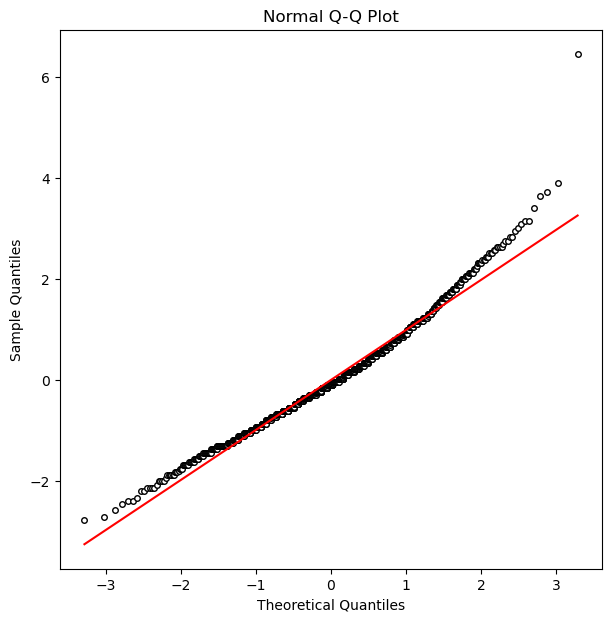

In [29]:
create_qq_plot(lc_rates_flat_z_scores)

## Dendrogram

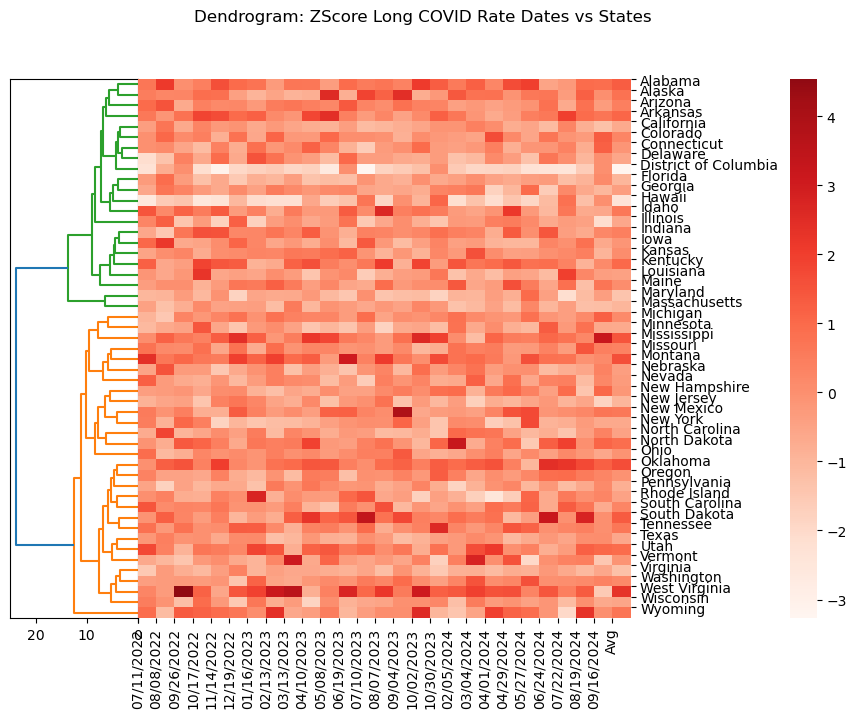

In [30]:
dendrogram(lc_rates_zscore)

# Get predictor variables
Separate predictor variables from dataframe

In [31]:
# list_of_cols_to_remove = [
#     'Avg', 'std_error', 'count',
#     'Sept 24 Value', 'Sept 24 Low CI', 'Sept 24 High CI']


# df_variables = get_variables_df(
# df_states,
# list_of_cols_to_remove,
# pattern="^[0-9]+$"
# )


# This will be used for BVS as the target variable later on
list_of_cols_to_remove = ['Avg']  

df_variables = get_variables_df(
    df_states,
    list_of_cols_to_remove,
    pattern_date="\d{2}/\d{2}/\d{4}"
)

In [32]:
df_variables.describe()

,Urban,Rural,Conservative,Moderate,Liberal,Below Poverty Line,White,Black,AI_AN,Asian,NHPI,Hispanic,Multiple,Percent of total pop with at least one dose,Percent of pop with an updated (bivalent) booster dose,Percent of 5+ pop with a completed primary series,Percent of 12+ pop with at least one dose,Percent of 18+ pop with a completed primary series,Percent of 65+ pop with a completed primary series,Paid sick leave,Medicaid expansion,Eviction moratoria duration
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,72.974510,27.025490,36.921569,33.392157,23.352941,12.313725,0.665471,0.112706,0.015072,0.046352,0.003541,0.108229,0.048628,79.566667,18.103922,72.605882,86.343137,78.203922,92.405882,0.313725,0.813725,294.803922
std,15.167213,15.167213,7.260422,3.092432,5.610075,2.721692,0.162677,0.103861,0.028291,0.053442,0.013422,0.095826,0.036306,10.916715,6.578904,10.008125,8.369451,8.945054,3.253639,0.468623,0.366889,347.627273
min,35.100000,0.000000,15.000000,27.000000,12.000000,6.800000,0.212881,0.005526,0.001459,0.008937,0.000240,0.016769,0.021177,61.800000,6.800000,56.600000,70.900000,63.300000,84.200000,0.000000,0.000000,0.000000
25%,63.900000,13.950000,32.500000,31.000000,20.000000,10.450000,0.569132,0.035174,0.002341,0.018988,0.000420,0.044280,0.031388,69.750000,12.850000,63.450000,78.500000,69.750000,89.550000,0.000000,1.000000,57.500000
50%,73.000000,27.000000,39.000000,33.000000,23.000000,12.000000,0.695530,0.075402,0.004396,0.031290,0.000683,0.083772,0.039490,78.400000,17.100000,71.200000,86.900000,77.700000,94.500000,0.000000,1.000000,114.000000
75%,86.050000,36.100000,42.000000,35.500000,27.500000,13.350000,0.780268,0.148758,0.009580,0.052204,0.001575,0.125911,0.056124,90.650000,22.400000,79.400000,95.000000,84.650000,95.000000,1.000000,1.000000,511.000000
max,100.000000,64.900000,50.000000,42.000000,36.000000,19.100000,0.921946,0.433571,0.148749,0.358978,0.095339,0.454334,0.271867,95.000000,34.300000,95.000000,95.000000,95.000000,95.000000,1.000000,1.000000,1221.000000


In [33]:
len(df_variables.columns)

22

In [34]:
df_variables.columns

Index(['Urban', 'Rural', 'Conservative', 'Moderate', 'Liberal',
       'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'NHPI',
       'Hispanic', 'Multiple', 'Percent of total pop with at least one dose',
       'Percent of pop with an updated (bivalent) booster dose',
       'Percent of 5+ pop with a completed primary series',
       'Percent of 12+ pop with at least one dose',
       'Percent of 18+ pop with a completed primary series',
       'Percent of 65+ pop with a completed primary series', 'Paid sick leave',
       'Medicaid expansion', 'Eviction moratoria duration'],
      dtype='object')

# Visualize Predictors Variables vs Target Variable

In [35]:
# plot_hist(df_variables)

In [36]:
# for var in df_variables.columns: 
#     plt.scatter(lc_rates[["Avg"]], df_variables[[var]])
#     plt.title(var)
#     plt.show()
    
# plot_scatter(lc_rates, df_variables, col_target='Avg')

In [37]:
len(df_variables[df_variables['Paid sick leave'] == 0])

35

In [38]:
len(df_variables[df_variables['Paid sick leave'] == 1])

16

# Investigate correlations between variables

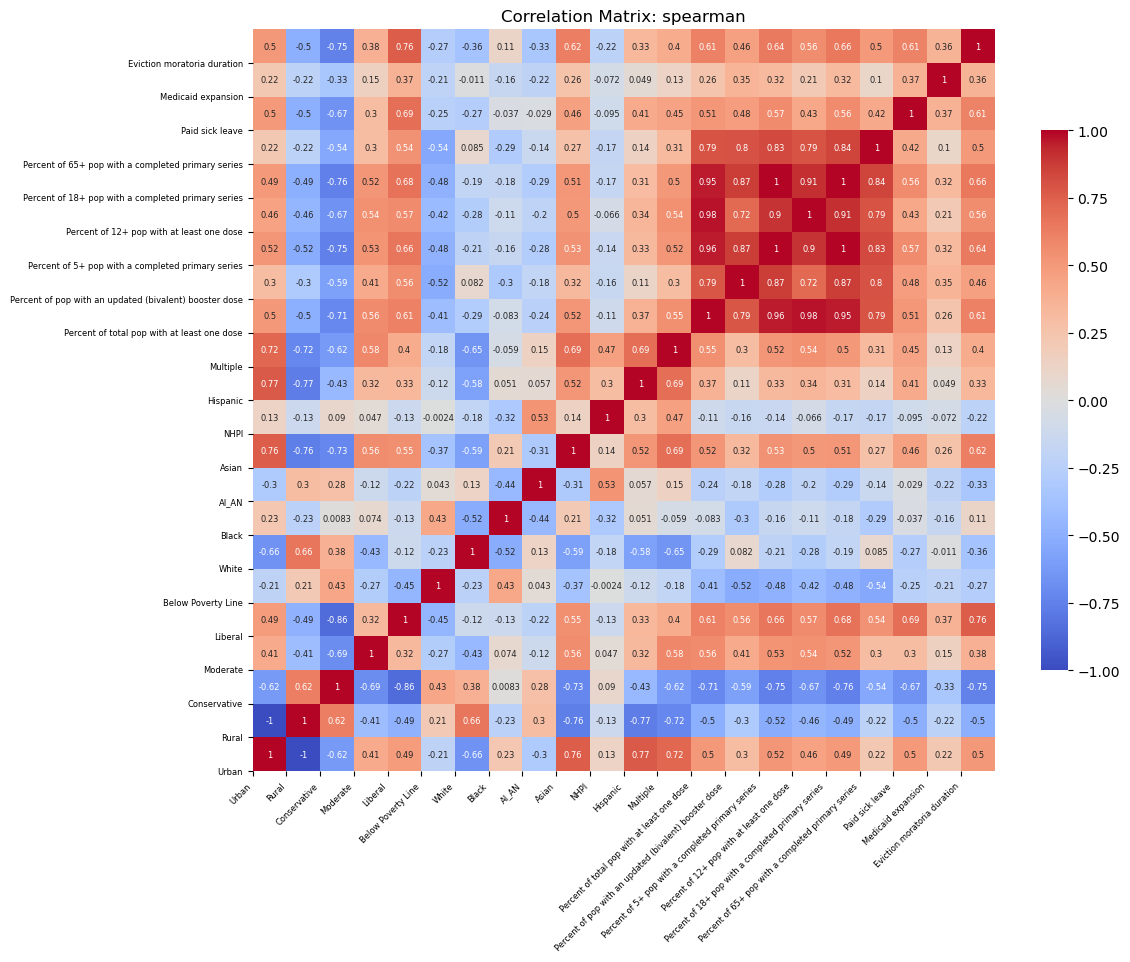

In [39]:
plot_correlation_matrix(
    df_variables,
    method='spearman',
    plot_title="Variable Correlations",
    corr_label_size=6,
    axis_label_size=6,
    fig_size=(12, 12),
    save_image=False,
    image_path="results/data_exploration/v11_correlation_matrix_kendall.png"
)

In [40]:
df_variable_correlations = calc_variable_correlations(df_variables)

In [41]:
df_variable_correlations.head(25)

,Variable 1,Variable 2,Correlation
0,Urban,Rural,-1.000000
1,Percent of 5+ pop with a completed primary series,Percent of 18+ pop with a completed primary series,0.997036
2,Percent of total pop with at least one dose,Percent of 12+ pop with at least one dose,0.976094
3,Percent of total pop with at least one dose,Percent of 5+ pop with a completed primary series,0.955817
4,Percent of total pop with at least one dose,Percent of 18+ pop with a completed primary series,0.954799
5,Percent of 12+ pop with at least one dose,Percent of 18+ pop with a completed primary series,0.906311
6,Percent of 5+ pop with a completed primary series,Percent of 12+ pop with at least one dose,0.904325
7,Percent of pop with an updated (bivalent) booster dose,Percent of 5+ pop with a completed primary series,0.873085
8,Percent of pop with an updated (bivalent) booster dose,Percent of 18+ pop with a completed primary series,0.868018
9,Conservative,Liberal,-0.858659


## Pair down variables given correlations

Types of correlations considered: 

- Pearson Correlation:
    - Primarily measures the strength of a linear relationship between two variables.   
- Spearman Correlation:
    - Measures the strength of a monotonic relationship between two variables.
    - As one variable increases, the other variable either consistently increases or consistently decreases.   
    - This can include non-linear trends like curves or S-shapes.

Chose pearson for simplicity.

In [42]:
# removed_variables_list, df_cleaned = calc_variable_correlations_with_removal(
#     df_variables,
#     lc_rates['Avg'],
#     method='pearson',
#     threshold = 0.7
# )

removed_variables_list, df_variables_cleaned = calc_variable_correlations_with_removal_lc_rates(
    df=df_variables, 
    target_var=pd.Series(lc_rates['Avg']),
    method='pearson',
    threshold = 0.65
)

corr_var_target["Urban"]: -0.6276044523367557
corr_var_target["Rural"]: 0.6276044523367558
corr_var_target["Liberal"]: -0.5358645203463257
corr_var_target["Conservative"]: 0.6867807840225538


In [43]:
removed_variables_list

['Urban',
 'Eviction moratoria duration',
 'Percent of 65+ pop with a completed primary series',
 'Percent of total pop with at least one dose',
 'Percent of 5+ pop with a completed primary series',
 'NHPI',
 'Moderate',
 'Paid sick leave',
 'Percent of 18+ pop with a completed primary series',
 'Percent of pop with an updated (bivalent) booster dose',
 'Liberal',
 'Percent of 12+ pop with at least one dose',
 'Multiple']

In [44]:
for col in df_variables_cleaned.columns:
    print(col) 

Rural
Conservative
Below Poverty Line
White
Black
AI_AN
Asian
Hispanic
Medicaid expansion


### Add back in race data based off of prior knowledge

In [45]:
prior_knowledge_cols = [
    'NHPI',
    'Multiple'
]

# Select the specified columns from df2
df_var_subset = df_variables[prior_knowledge_cols]

# Concatenate df1 and df2_selected along the columns (axis=1)
df_variables_final = pd.concat([df_variables_cleaned, df_var_subset], axis=1)


In [46]:
for col in df_variables_final.columns:
    print(col) 

Rural
Conservative
Below Poverty Line
White
Black
AI_AN
Asian
Hispanic
Medicaid expansion
NHPI
Multiple


---
# Bayesian Variable Selection
---

### Variable Sensitivity Analysis - Hyperparameter Tuning using Optuna

In [47]:
# model_params = {
#     # "alpha_sigma": 3, # Typical values 1 - 5
#     # "beta_sigma": 0.75, # Typical values 0.1 - 1
#     "mu": 0, # Typical value 0
#     # "sigma": 2, # Typical values 1 - 5
#     # "prob_of_success": 0.2, # Typical values 0.1 - 0.5
#     "draws": 2000, # Defaults to 2000 in pm
#     "kernel": pm.smc.IMH, # Defaults to IMH for Monte Carlo in pm
#     # "kernel": pm.smc.kernels.IMH, # Defaults to IMH for Monte Carlo in pm
#     # "kernel": pm.smc.MH, # Defaults to IMH for Monte Carlo in pm
#     "scale_predictors": True,
#     "scale_function": "z-score",
#     "predictors_to_scale": [
#         "Urban",
#         "Conservative",
#         "Moderate",
#         "Liberal",
#         "Below Poverty Line",
#         'White',
#         'Black',
#         'AI_AN',
#         'Asian',
#         'NHPI',
#         'Hispanic',
#         'Multiple',
#         "Percent of total pop with at least one dose",
#         "Percent of pop with an updated (bivalent) booster dose",
#         'Medicaid expansion',
#         "Eviction moratoria duration"
#     ],
#     "cores": 4, # Number of CPUs
# }


# model_params = {
#     "mu": 0, # Typical value 0
#     "draws": 2000, # Defaults to 2000 in pm
#     "kernel": pm.smc.IMH, # Defaults to IMH for Monte Carlo in pm
#     "scale_predictors": True,
#     "scale_function": "z-score",
#     "cores": 4, # Number of CPUs
# }

# model_params = {
#     "mu": 0, # Typical value 0
#     "draws": 100, # Defaults to 2000 in pm
#     "kernel": pm.smc.IMH, # Defaults to IMH for Monte Carlo in pm
#     "scale_predictors": True,
#     "scale_function": "z-score",
#     "cores": 4, # Number of CPUs
# }

In [48]:
best_params = run_optuna_hyperparameter_optimization(
    df_variables_final, 
    lc_rates['Avg'],
    model_params,
    n_trials=100,
    sampler_type="QMC",
    study_name="LC_hyperparam_optimization_culled_vars_QMC_IMH_2025" # Unique id of hyperparameters study.
)

NameError: name 'model_params' is not defined

In [ ]:
best_params = run_optuna_hyperparameter_optimization(
    df_variables_final, 
    lc_rates['Avg'],
    model_params,
    n_trials=100,
    sampler_type="TPE",
    study_name="LC_hyperparam_optimization_culled_vars_TPE_IMH_2025" # Unique id of hyperparameters study.
)

In [ ]:
pm.__version__

In [ ]:
import sqlite3

def show_all_database_objects(db_file):
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()

    # Get a list of all objects with a non-null type
    cursor.execute("SELECT name, type FROM sqlite_master WHERE type IS NOT NULL;")
    objects = cursor.fetchall()

    for name, type in objects:
        print(f"\nObject: {name}")
        print(f"Type: {type}")

        if type in ('table', 'view'):
            cursor.execute(f"SELECT * FROM {name}")
            rows = cursor.fetchall()

            # Print column headers
            column_names = [description[0] for description in cursor.description]
            print('\t'.join(column_names))

            # Print rows with formatted output
            for row in rows:
                print('\t'.join(str(value) for value in row))
        elif type == 'index':
            # Print index details
            cursor.execute(f"PRAGMA index_info({name})")
            index_info = cursor.fetchall()
            print("Index Information:")
            for info in index_info:
                print(info)
        elif type == 'trigger':
            # Print trigger definition
            cursor.execute(f"SELECT sql FROM sqlite_master WHERE type='trigger' AND name='{name}'")
            trigger_definition = cursor.fetchone()[0]
            print("Trigger Definition:")
            print(trigger_definition)
        else:
            print("Not a table, view, or index. Cannot display contents.")

    conn.close()

In [ ]:
db_optuna_qmc = "LC_hyperparam_optimization_culled_vars_QMC_IMH_2025.db"
show_all_database_objects(db_optuna_qmc)

In [ ]:
db_optuna_tpe = "LC_hyperparam_optimization_culled_vars_TPE_IMH_2025.db"
show_all_database_objects(db_optuna_tpe)


In [49]:
def find_best_trial_and_params(db_file):
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()

    # Find the trial with the most negative value_json
    cursor.execute("SELECT trial_id, value_json FROM trial_user_attributes ORDER BY value_json DESC LIMIT 1")
    best_trial_id, value_json = cursor.fetchone()

    # Retrieve the parameters for the best trial
    cursor.execute("""
        SELECT param_name, param_value
        FROM trial_params
        WHERE trial_id = ?
    """, (best_trial_id,))

    best_params = {}
    for param_name, param_value in cursor.fetchall():
        best_params[param_name] = param_value
        print(param_name)

    print("The best trial was:")
    print(f"Trial ID: {best_trial_id}")
    print(f"Value objective: {value_json}")
    print(f"Best Params: {best_params}")
        
    conn.close()

In [50]:
find_best_trial_and_params(db_optuna_qmc)


NameError: name 'db_optuna_qmc' is not defined

In [51]:
find_best_trial_and_params(db_optuna_tpe)

NameError: name 'db_optuna_tpe' is not defined

In [52]:
# Run the BVS model with the best hyperparameters

model_params_qmc = {
    "experiment_name":"LC_household_pulse_v11_db_optuna_params_qmc_trial_36_jan_2025",
    "alpha_sigma": 8.5, # Typical values 1 - 5
    "beta_sigma": 0.1, # Typical values 0.1 - 1
    "mu": 0, # Typical value 0
    "sigma": 5, # Typical values 1 - 5
    "prob_of_success": 0.4, # Typical values 0.1 - 0.5
    "draws": 2000, # Defaults to 2000 in pm
    "kernel": pm.smc.IMH, # Defaults to IMH for Monte Carlo in pm
    "scale_predictors": True,
    "save_model": False,
    "scale_function": "z-score",
    "predictors_to_scale": [
        "Rural"
        "Conservative"
        "Below Poverty Line"
        "White"
        "Black"
        "AI_AN"
        "Asian"
        "Hispanic"
        "Medicaid expansion"
    ],
    "cores": 4, # Number of CPUs
}

best_trace_qmc = bayesian_variable_selection_multiple(
    df_variables_final,
    pd.DataFrame(lc_rates['Avg']),
    model_params_qmc
)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


In [53]:
model_params_tpe = {
    "experiment_name":"LC_household_pulse_v11_db_optuna_params_tpe_trial_34_jan_2025",
    "alpha_sigma": 10, # Typical values 1 - 5
    "beta_sigma": 0.1, # Typical values 0.1 - 1
    "mu": 0, # Typical value 0
    "sigma": 3, # Typical values 1 - 5
    "prob_of_success": 0.5, # Typical values 0.1 - 0.5
    "draws": 2000, # Defaults to 2000 in pm-
    "kernel": pm.smc.IMH, # Defaults to IMH for Monte Carlo in pm
    "scale_predictors": True,
    "scale_function": "z-score",
    "predictors_to_scale": [
        "Rural"
        "Conservative"
        "Below Poverty Line"
        "White"
        "Black"
        "AI_AN"
        "Asian"
        "Hispanic"
        "Medicaid expansion"
    ],
    "cores": 4, # Number of CPUs
}

best_trace_tpe = bayesian_variable_selection_multiple(
    df_variables_final,
    pd.DataFrame(lc_rates['Avg']),
    model_params_tpe
)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


### Resume Study

In [ ]:
# # Add stream handler of stdout to show the messages
# optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))

# study_name = "LC_hyperparam_optimization"  # Unique id of hyperparameters study.
# storage_name = "sqlite:///{}.db".format(study_name) # DB to store hyperparameters study results

# # Create optuna hyperparameters study
# study = optuna.create_study(
#     direction='minimize',  # Optimize objective function
#     storage=storage_name,  # Store results in local DB
#     load_if_exists=True,  # Resume hyperparameter study if exists
#     sampler=restored_sampler  # Sampler whose seed argument is specified for reproducibility
# )

# # Optimize hyperparameters (sensitivity analysis)
# study.optimize(objective, n_trials=20)

# # Get the best hyperparameters from the study
# best_params = study.best_params

# # Run the BVS model with the best hyperparameters
# best_trace = bayesian_variable_selection_multiple(
#     df_variables,
#     pd.DataFrame(lc_rates['Avg']),
#     best_params,
#     experiment_name="LC_household_pulse_v11_with_race_zscore_norm_optuna"
# )

In [ ]:
# study.trials

In [ ]:
best_params

### Bayesian Variable Selection Workflow

In [ ]:
# model_params ={    
#     "predictors_to_scale": [
#         "Urban",
#         "Rural",
#         "Conservative",
#         "Moderate",
#         "Liberal",
#         "Political Don't know",
#         "Below Poverty Line",
#         "Percent of total pop with at least one dose",
#         "Percent of pop with an updated (bivalent) booster dose",
#         "Eviction moratoria duration"
#     ]
# }
# X = df_variables.values  # Variables affecting/not affecting LC rates
# X_scaled = X.copy()
# scaler = StandardScaler() 
# columns_to_scale = [df_variables.columns.get_loc(col) for col in model_params["predictors_to_scale"]]
# X_scaled[:, columns_to_scale] = scaler.fit_transform(X[:, columns_to_scale])
# # X_scaled
# columns_to_scale

In [ ]:
# model_params = {
#     # "experiment_name":"LC_household_pulse_v11_with_race_zscore_norm"
#     "experiment_name":"test",
#     "alpha_sigma": 3, # Typical values 1 - 5
#     "beta_sigma": 0.75, # Typical values 0.1 - 1
#     "mu": 0, # Typical value 0
#     "sigma": 2, # Typical values 1 - 5
#     "prob_of_success": 0.2, # Typical values 0.1 - 0.5
#     "draws": 10, # Defaults to 2000 in pm
#     "kernel": pm.smc.IMH, # Defaults to IMH for Monte Carlo in pm
#     "scale_predictors": True,
#     "scale_function": "z-score",
    # "predictors_to_scale": [
    #     "Urban",
    #     "Conservative",
    #     "Moderate",
    #     "Liberal",
    #     "Below Poverty Line",
    #     'White',
    #     'Black',
    #     'AI_AN',
    #     'Asian',
    #     'NHPI',
    #     'Hispanic',
    #     'Multiple',
    #     "Percent of total pop with at least one dose",
    #     "Percent of pop with an updated (bivalent) booster dose",
    #     'Medicaid expansion',
    #     "Eviction moratoria duration"
    # ],
    "cores": 4, # Number of CPUs
}


In [ ]:
# # Run BVS on just the Avg column, but can select more target variables if desired
all_variables_avg_10_v2 = bayesian_variable_selection_multiple(
    df_variables,
    pd.DataFrame(lc_rates['Avg']),
    model_params
)

In [ ]:
# Run BVS on all target variables separately
# all_variables= bayesian_variable_selection_multiple(df_variables, lc_rates)

---
# Assess performance of model and inspect results
---

### How to asses performance of inference: 

- r_hat
    - It should be close to 1 for well-converged chains. This suggests that the chains have converged and are mixing well, meaning they are exploring the parameter space in a similar manner.
    - Values significantly greater than 1 indicate potential problems with the sampling process. This indicates that the chains might not have converged or are mixing poorly. 
- Effective sample size: 
    - A measure of the number of independent samples in the posterior distribution.
    - A low ESS can indicate autocorrelation or poor mixing.
    - A high ESS suggests that the posterior samples are relatively independent.
- Trace plots
    - Visualize the MCMC traces of the parameters.
    - Look for convergence, mixing, and autocorrelation.
    - The chains should appear to mix well and not exhibit systematic patterns.
- Posterior distributions
    - They should be well-behaved and not show extreme skewness or multimodality.
    - Check for unimodality and reasonable ranges for the parameters.
    - Extreme values or multiple peaks might indicate issues.
- WAIC or LOO
    - Compare the fit of the model to the data.
    - A lower WAIC or LOO value generally indicates a better fit.
- Inclusion Probabilities
    - High probabilities suggest the variable is likely important.
- Highest Density Interval
    - Highest Density:
        - HDIs are intervals that contain the highest density of probability mass from the posterior distribution.
    - Credible Interval:
        - They represent a range of values that the parameter is likely to fall within with a specified probability (e.g., 95%).
    - Symmetric or Asymmetric:
        - HDIs can be symmetric or asymmetric, depending on the shape of the posterior distribution. 
        - A narrower HDI indicates less uncertainty about the parameter's value.
        - An asymmetric HDI suggests that the posterior distribution is skewed.
    -  Skewed HDIs
        - Nonlinear relationships:
            - The relationship between the variables in the model might be nonlinear, leading to a skewed posterior.
            - The skewness towards the negative values might indicate a potential nonlinear relationship or an informative prior that pulls the posterior towards the negative side.
        - Prior choice:
            - The choice of prior distribution can influence the shape of the posterior.
        - Data characteristics:
            - Outliers or other data characteristics can skew the posterior distribution.


### How to improve inference performance when it is subpar

- Increase the number of samples:
    - This can help improve convergence and reduce autocorrelation.
- Adjust the sampling algorithm:
    - Try different samplers (e.g., NUTS, HMC) or tune the parameters of your current sampler.
- Reparameterize your model:
    - Rethinking the parameterization of your model can sometimes improve mixing and convergence.
- Consider alternative priors:
    - Experiment with different prior distributions to see if they improve the sampling behavior.
- r_hat not close to 1 could be due to: 
    - Insufficient number of samples: Increasing the number of samples might improve convergence.
    - Poor initialization: The starting values for the chains might be too far from the target distribution.
    - Model complexity: Complex models can be more challenging to sample from.
    - Sampling algorithm issues: The MCMC algorithm might not be suitable for your model. xperiment with different MCMC algorithms like NUTS, HMC, or Metropolis-Hastings to see if they improve convergence.

### Set inference data variables for consistant plotting

In [99]:
inference_results_qmc = best_trace_qmc[0]

inference_results_tpe = best_trace_tpe[0]
# inference_results = all_variables_avg_10_v2[0]
# inference_results_tpe

In [101]:
inference_variables_tpe = df_variables_final.columns
inference_states_tpe = lc_rates.index

inference_variables_qmc = df_variables_final.columns
inference_states_qmc = lc_rates.index

print("Variable numerical index vs variable name TPE:")
for i in range(len(inference_variables_tpe)):
    print(f"{i}: {inference_variables_tpe[i]}")

print("Variable numerical index vs variable name QMC:")
for i in range(len(inference_variables_qmc)):
    print(f"{i}: {inference_variables_qmc[i]}")
    
# print()
# print("State numerical index vs state name:")
# for i in range(len(inference_states)):
#     print(f"{i}: {inference_states[i]}")

Variable numerical index vs variable name TPE:
0: Rural
1: Conservative
2: Below Poverty Line
3: White
4: Black
5: AI_AN
6: Asian
7: Hispanic
8: Medicaid expansion
9: NHPI
10: Multiple
Variable numerical index vs variable name QMC:
0: Rural
1: Conservative
2: Below Poverty Line
3: White
4: Black
5: AI_AN
6: Asian
7: Hispanic
8: Medicaid expansion
9: NHPI
10: Multiple


In [59]:
len(inference_variables_tpe)

11

### arviz.InferenceData obj inspection

In [60]:
inference_results_tpe

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

### Get posterior, sample stats, observed data

In [69]:
def extract_inference_results(inference_results):
    posterior_avg_df  = inference_results.to_dataframe()
    sample_stats_avg_df = inference_results.sample_stats.to_dataframe()
    observed_data_avg_df = inference_results.observed_data.to_dataframe()
    
    return posterior_avg_df, sample_stats_avg_df, observed_data_avg_df

In [70]:
posterior_avg_df_tpe, sample_stats_avg_df_tpe, observed_data_avg_df_tpe = extract_inference_results(inference_results_tpe)

In [152]:
# posterior_avg_df  = inference_results.to_dataframe()
# sample_stats_avg_df = inference_results.sample_stats.to_dataframe()
# observed_data_avg_df = inference_results.observed_data.to_dataframe()

In [153]:
# posterior_avg_df.head(10)

In [154]:
# sample_stats_avg_df.head(10)

In [155]:
# observed_data_avg_df.head(10)

In [156]:
# az.plot_energy(all_variables_avg_10[0]);

### Sumary stats

In [103]:
# Grab summary statistics
summary_df_tpe = az.summary(inference_results_tpe, round_to=4)
summary_df_tpe.head(10)

summary_df_qmc = az.summary(inference_results_qmc, round_to=4)
summary_df_qmc.head(10)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.0444,0.4294,-0.1690,1.1854,0.0057,0.0040,4680.3352,4240.9485,1.0005
beta[1],0.0499,0.4117,0.0000,1.1637,0.0054,0.0038,4644.0390,3723.7085,1.0030
beta[2],0.0289,0.3556,-0.5865,0.4132,0.0055,0.0039,3374.5291,2565.8669,1.0033
beta[3],0.0402,0.4501,-0.2233,1.2750,0.0059,0.0042,4874.8830,4903.8354,1.0002
beta[4],-0.0272,0.3712,-0.6089,0.5115,0.0048,0.0034,4163.6950,3879.5177,1.0013
beta[5],0.0254,0.3439,-0.3193,0.4359,0.0047,0.0033,4099.0904,4380.8215,1.0013
beta[6],-0.0574,0.5687,-1.1080,0.5540,0.0101,0.0072,3991.4817,2937.5190,1.0017
beta[7],-0.0048,0.3535,-0.3344,0.4401,0.0048,0.0034,4006.4768,4523.6811,1.0013
beta[8],-0.0080,0.3368,-0.3091,0.2739,0.0050,0.0035,3954.8151,3588.8121,1.0026
beta[9],-0.0019,0.4786,-0.6677,0.5481,0.0068,0.0048,4917.9209,5011.4864,1.0019


### R_hat and HDI

- what is r_hat?
    - It is a diagnostic statistic used in Bayesian analysis to assess the convergence of Markov Chain Monte Carlo (MCMC) sampling
    - It is calculated by comparing the variance of the posterior distribution across multiple chains to the within-chain variance.
    - It provides a quantitative measure of how well the MCMC sampler has explored the parameter space.
    
- What is HDI?
    - HDI stands for Highest Density Interval.
    - It's a Bayesian credible interval that provides a probabilistic range of plausible values for a parameter.
    
- How to improve: 
    - Tune: Increase the tune parameter to allow the sampler more time to adapt and find a good starting point.
    - Draws: Increase the draws parameter to collect more samples from the posterior distribution.
    - NUTS: If you're using NUTS, experiment with different target_accept and max_treedepth values to fine-tune its behavior.
    - Alternative Samplers: Consider using other samplers like Metropolis-Hastings or Hamiltonian Monte Carlo if NUTS is struggling.
    
- Notes: 
    - "Ultimately, we are interested in the estimates of beta, the set of predictor coefficients. Passing beta to plot_trace would generate a very crowded plot, so we will use plot_forest instead, which is designed to handle vector-valued parameters."
        - From: https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html
    - r_hat should be close to 1
    - A narrower HDI indicates less uncertainty about the parameter's value.

In [74]:
az.plot_forest(summary_df_tpe, var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True);

ValueError: Can only convert xarray dataarray, xarray dataset, dict, pytree (if 'dm-tree' is installed), netcdf filename, numpy array, pystan fit, emcee fit, pyro mcmc fit, numpyro mcmc fit, cmdstan fit csv filename, cmdstanpy fit to InferenceData, not DataFrame

### Effective Sample Size

Interpretation: 
- Low ESS:
    - A low ESS suggests that the samples might be correlated or that the sampler is struggling to explore the parameter space efficiently.
    - This can lead to less reliable inference results.
- High ESS:
    - A high ESS indicates that the samples are more independent, providing a more accurate representation of the posterior distribution.
    - This means that the information in your posterior distribution is well-represented by the samples.
    
Factors Affecting ESS:
- Model Complexity:
    - More complex models can lead to lower ESS.
- Sampling Algorithm:
    - The choice of MCMC algorithm can affect ESS.
    - Some algorithms might be more efficient in certain situations.
- Number of Samples:
    - Increasing the number of samples can generally improve ESS, but there's a trade-off with computational cost.
    
Typical Range:
- While there's no strict threshold for a "good" ESS, values significantly lower than the number of samples can be a cause for concern.
- A general rule of thumb is that the ESS should be at least 100 for reliable inference.
- However, this can vary depending on the specific context and the complexity of the model.

Bulk vs Tail ESS: 
- ESS Bulk:
    - This refers to the effective sample size (ESS) of the bulk of the posterior distribution.
    - It's a measure of how many independent draws the MCMC sampler has effectively produced.
- ESS Tail:
    - This refers to the ESS of the tails of the posterior distribution.
    - It's a measure of how well the sampler has explored the extreme values of the distribution.
    
- Values: 
    - Ideally, the ESS bulk and tail should be similar in magnitude.
    - A large difference between the two can indicate potential convergence issues or an insufficient number of samples.
    - If the ESS tail is significantly smaller than the ESS bulk, it suggests that the sampler may not have adequately explored the tails of the distribution.
- Shape:
    - Symmetrical:
        - If the posterior is roughly symmetrical, it suggests that the data is providing strong evidence for a particular range of parameter values.
    - Skewed:
        - A skewed posterior indicates that the data favors one tail of the distribution over the other.
        - This could be due to factors like outliers or non-linear relationships.
    - Multimodal:
        - A multimodal posterior suggests that the data supports multiple plausible parameter values.
        - This could be due to model misspecification or the presence of multiple local optima.  

Improving ESS:

- Increase the Number of Samples:
    - Run the MCMC sampler for longer.
- Consider a Different Sampler:
    - Experiment with different MCMC algorithms.
- Reparameterize the Model:
    - If possible, reparameterize the model to improve mixing.

In [75]:
def plot_ess(summary_df, variables, states):
    """Plots Effective Sample Size (ESS) for bulk and tail of
    specified variables across different covariate values.

    Args:
      summary_df (pd.DataFrame):
          A DataFrame containing the summary statistics 
          including ESS values for different variables and 
          covariates (states or variables).
          
      variables (list):
          A list of variable names to plot the ESS for.
          
      states (list):
          A list of state names (if plotting ESS by state).

    Returns:
        None:
            This function creates plots and does not return any value.
      
    Typical Usage Example: 
        This allows you to visually assess the convergence of the
        MCMC sampler for each variable and state, helping you identify
        potential issues with model fit or sampling efficiency.      
        
        plot_ess(summary_df, inference_variables, inference_states)
    """

    
    for i, var_name in enumerate(['beta', 'beta_raw', 'ind', 'mu']):
        pattern = f'{var_name}\[(\d+)\]'

        filtered_df = summary_df[summary_df.index.str.match(pattern)]
        
        fig, ax = plt.subplots(figsize=(20, 5), nrows=2, ncols=1, sharex=True)
        fig.suptitle(f"ESS bulk and tail: {var_name}")
            
        if var_name in ['beta', 'beta_raw', 'ind']:
            ax[0].plot(variables, filtered_df['ess_bulk'])
            ax[0].set_title("ess bulk")
            ax[1].plot(variables, filtered_df['ess_tail'])
            ax[0].set_title("ess tail")
            # plt.xlim(0, len(filtered_df['ess_bulk']))

            plt.xticks(rotation=90)
            plt.show()
            
        else: 
            ax[0].plot(states, filtered_df['ess_bulk'])
            ax[0].set_title("ess bulk")
            ax[1].plot(states, filtered_df['ess_tail'])
            ax[0].set_title("ess tail")
            # plt.xlim(0, len(filtered_df['ess_bulk']))

            plt.xticks(rotation=45)
            plt.show() 

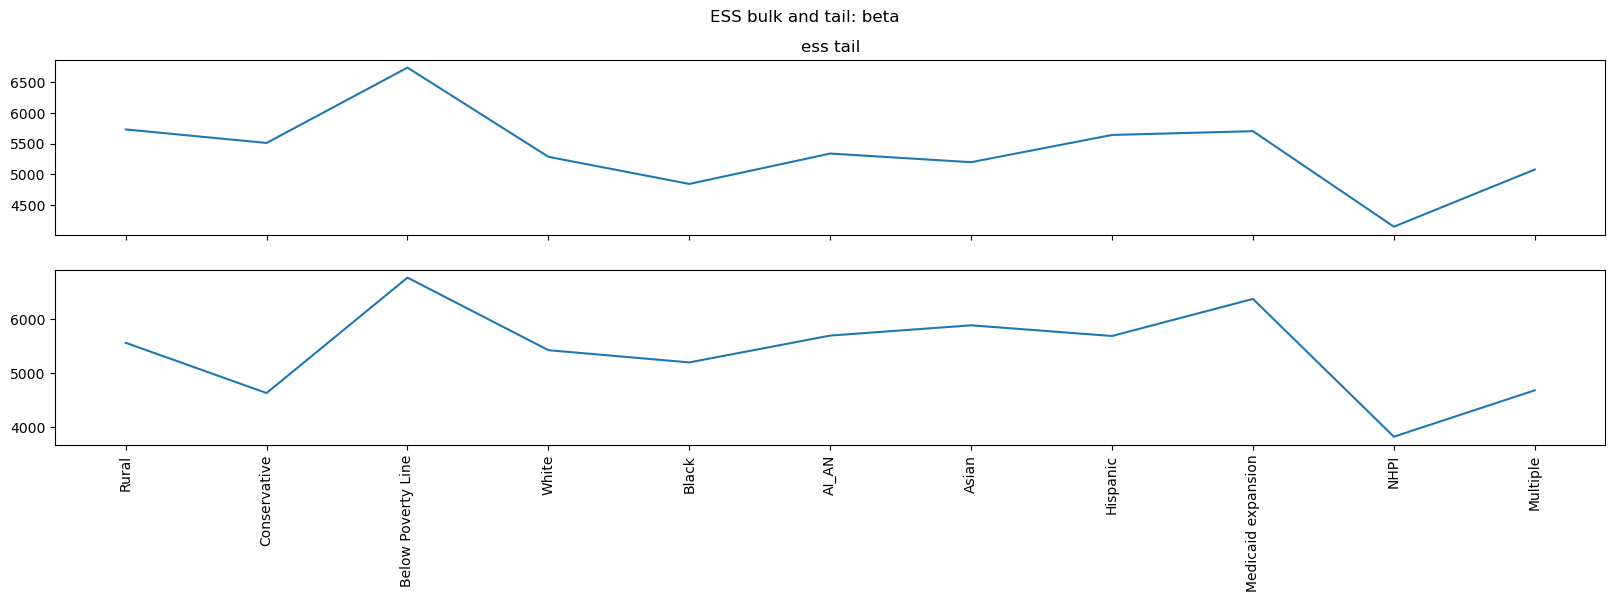

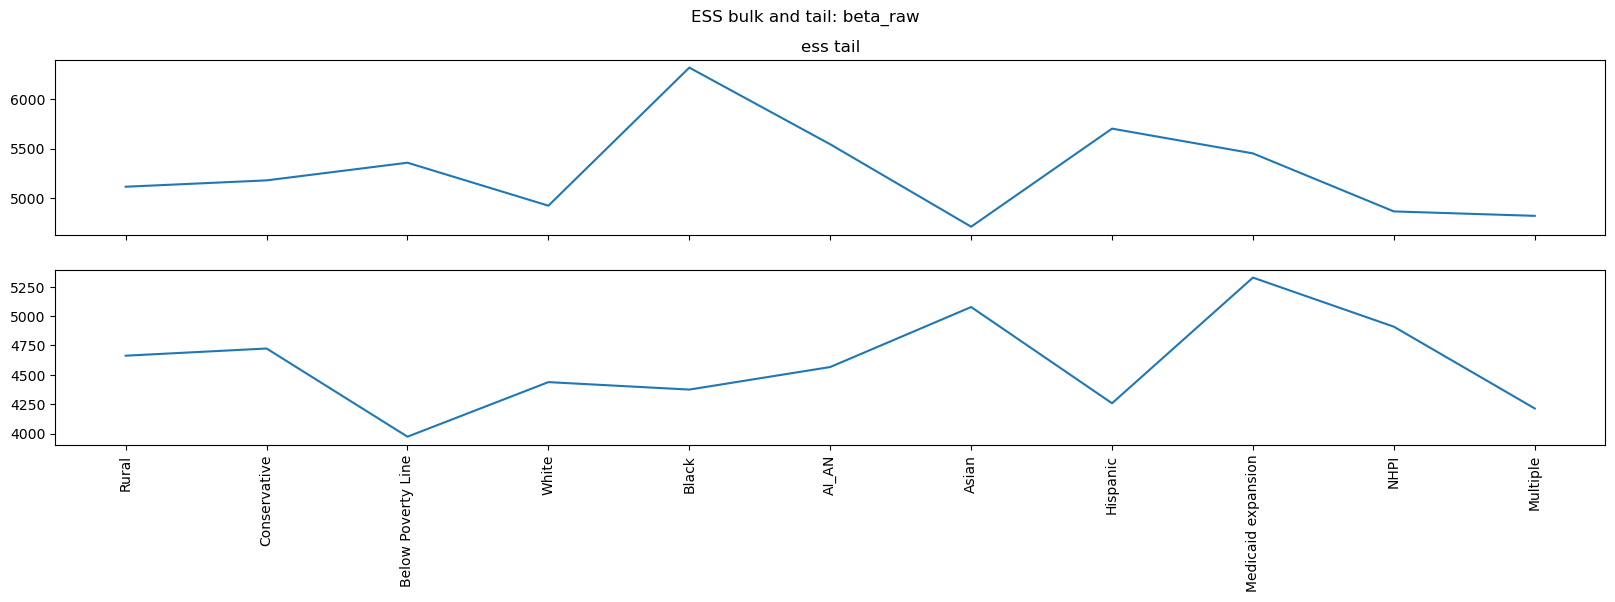

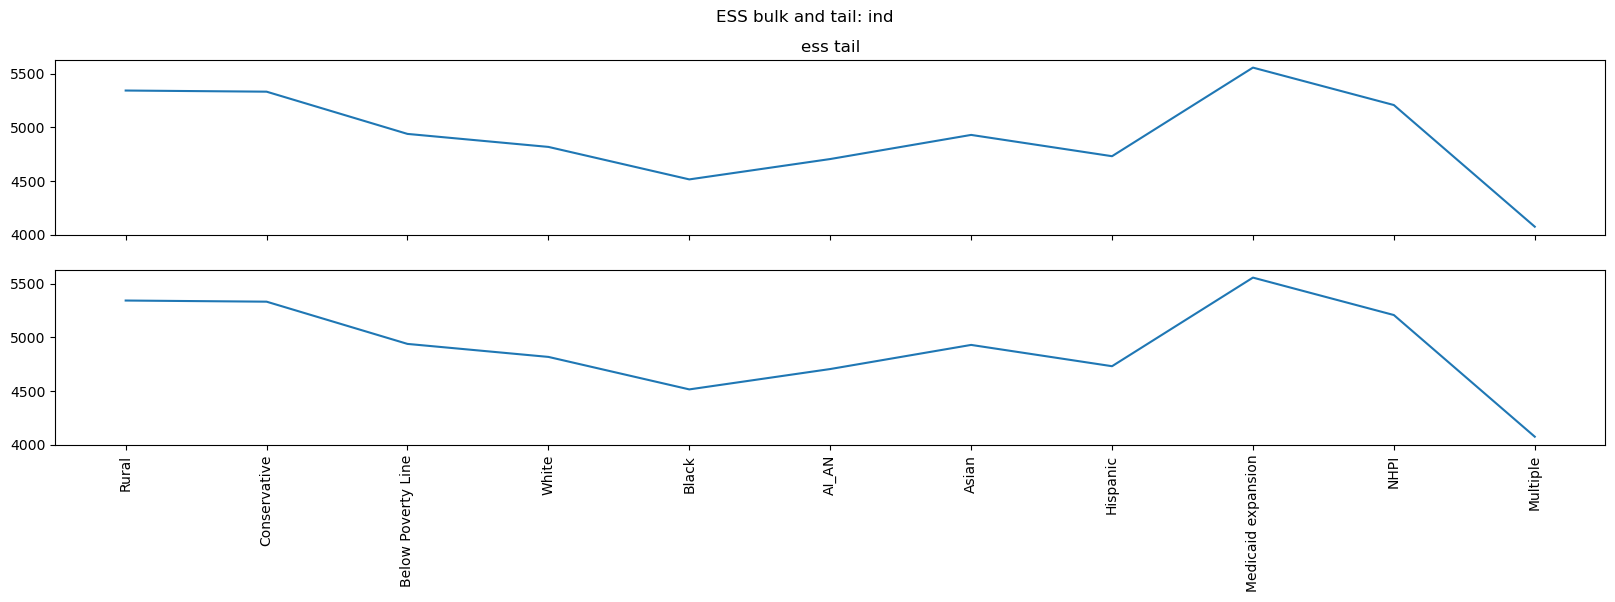

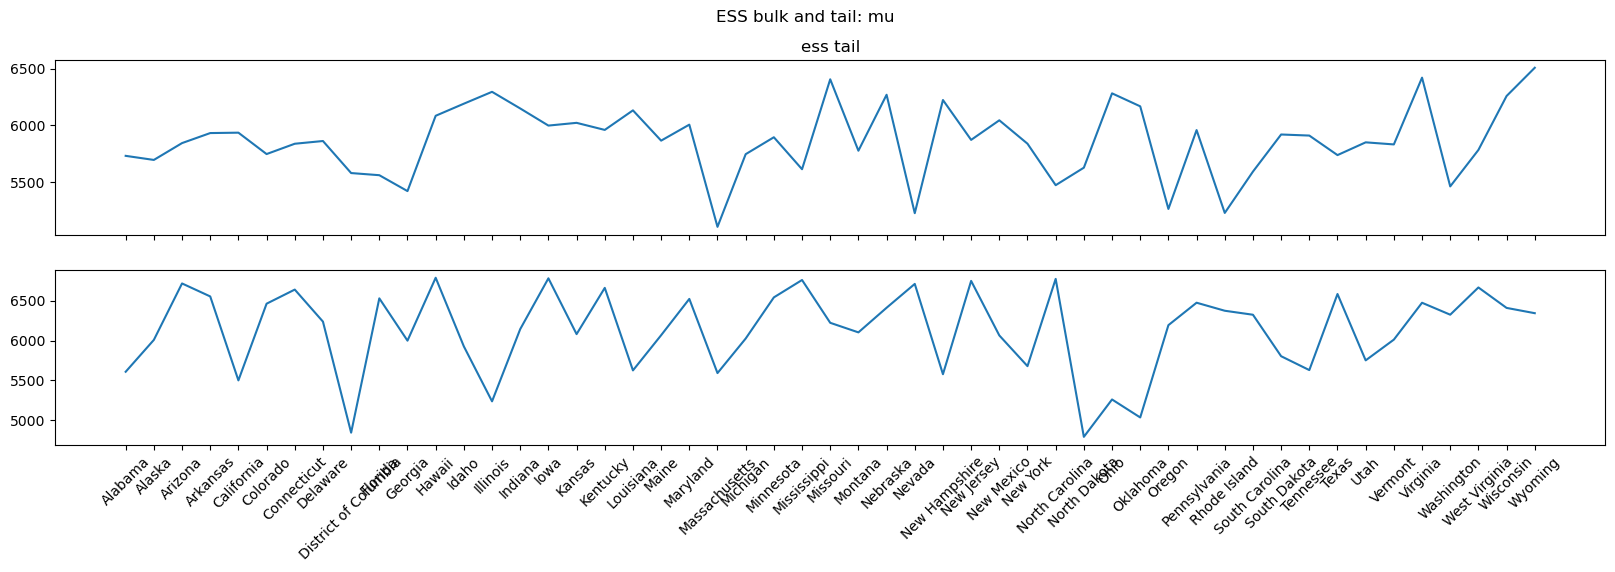

In [77]:
# Arviz method
# az.plot_ess(inference_results)
plot_ess(summary_df_tpe, inference_variables_tpe, inference_states_tpe)

### Trace Plots


- Density Plot:
    - Shape:
        - A symmetric, unimodal distribution indicates a well-defined posterior.
        - A skewed or multimodal distribution might suggest issues with the model or data.
    - Location:
        - The location of the peak indicates the most probable value of the parameter.
    - Spread:
        - The width of the distribution indicates the uncertainty around the parameter.
- Trace Plot:
    - Mixing:
        - The trace plot should show a well-mixed chain, meaning the sampler is exploring the parameter space effectively.
        - If the trace is stuck in a particular region, it might indicate convergence issues.
    - Stationarity:
        - The trace should appear stationary, meaning there are no clear trends or patterns over time.
        - A non-stationary trace might suggest that the sampler hasn't converged yet.
        
- Interpretation the Variables:
    - Beta:
        - The posterior distribution of beta indicates the importance of the corresponding features in the model.
        - A wider distribution suggests more uncertainty about the feature's importance.
        - Negative values indicate inverse relationships.
    - Beta_raw:
        - This represents the raw coefficients before feature selection.
        - A wider distribution might indicate that the feature is not strongly associated with the target variable.
    - Sigma:
        - The posterior distribution of sigma represents the uncertainty in the model's noise term.
        - A wider distribution indicates greater uncertainty.
        - Standard deviation of the noise term. A smaller value indicates less noise.
    - Ind:
        - The posterior distribution of ind represents the probability of each feature being included in the model.
        - A higher probability indicates a more important feature.
        - Indicator variables indicate whether a feature is included (1) or excluded (0) in the model.
    - Mu:
        - The posterior distribution of mu represents the uncertainty in the model's predictions.
        - Predicted mean values for the target variable.
    - Divergence:
        - Look for signs of divergence, such as sudden jumps in the trace plots or high R-hat values.

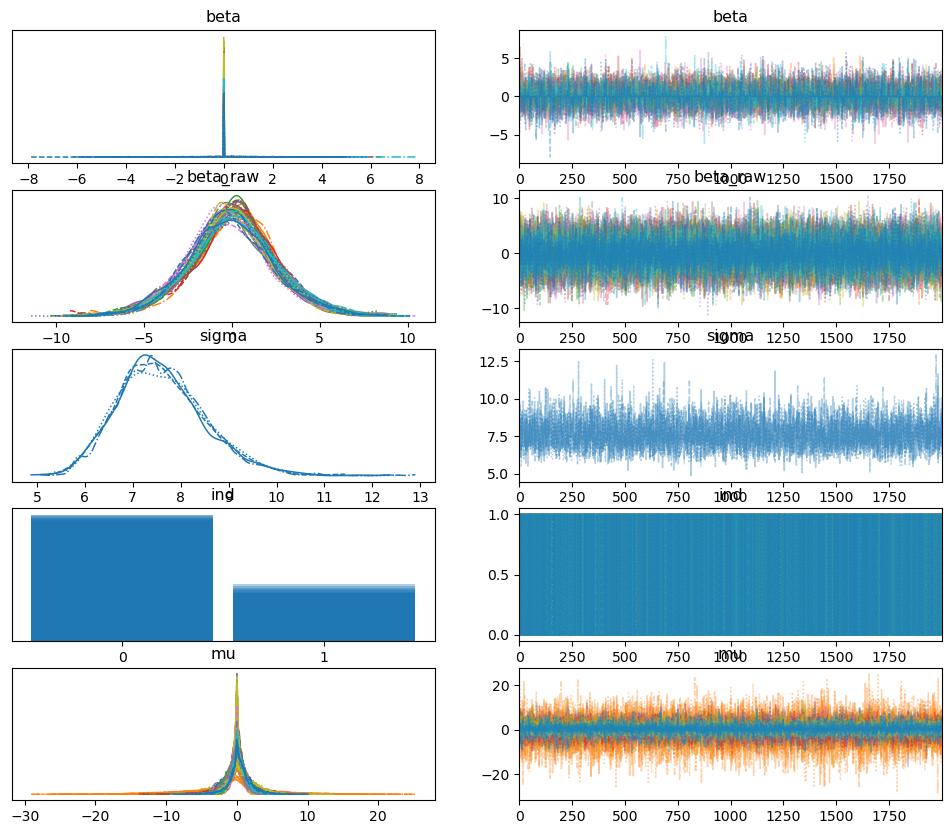

In [78]:
# Arviz method
# Left column are density plots which show the distribution of the parameter values.
# Right is the Trace Plot which plots the parameter values across MCMC iterations.
az.plot_trace(inference_results_tpe, var_names=["beta", "beta_raw", "sigma", "ind", "mu"]);

In [162]:
# def plot_result(
#     summary_df,
#     inference_variables, 
#     idx_pattern = r'beta\[(\d+)\]'
# ):
#     results = summary_df[summary_df.index.str.match(idx_pattern, regex=True)]
#     plt.plot(results, inference_variables)
#     plt.xticks(rotation=90)

#     plt.show()

### Posterior Distrubitions

In [163]:
# az.plot_posterior(inference_results)

### Model Fit

In [164]:
# # Log liklihood not in inference results. Need to add
# waic_score = az.waic(inference_results)  
# print(waic_score)

# loo_score = az.loo(inference_results)
# print(loo_score)

# ppc = az.from_pymc3(pm.sample_posterior_predictive(model, posterior_samples))


### Importance: np.abs(beta_means) * ind_means

- What is it? 
    - The importance variable typically represents a measure of the relative influence of different variables on a target variable in a Bayesian model.
    - It is often calculated by combining the posterior means of the coefficients (beta) with the inclusion probabilities (ind).
    - A higher importance value suggests that a variable is more likely to be influential in predicting the target variable.
    - The specific parameters that go into calculating importance can vary depending on the exact implementation, but generally include:
        - Posterior means of coefficients (beta): These represent the estimated effects of each variable on the target variable.
        - Inclusion probabilities (ind): These represent the probability that each variable is included in the model based on the posterior distribution.
- Notes: 
    - The importance metric is a relative measure and doesn't provide absolute values of effect size.
    - The typical range of values for the importance metric in Bayesian variable selection can vary widely depending on the specific problem, model complexity, and scale of the data.
    - Factors affecting the range:
        - Model complexity: More complex models with many variables and interactions might result in a wider range of importance values.
        - Data scale: The scale of the variables in the data can affect the scale of the coefficients and inclusion probabilities, which in turn affects the importance values.
        - Prior distributions: The choice of prior distributions for the coefficients and inclusion probabilities can influence the range of possible values.
- Higher values:
    - Variables with higher importance values are generally considered more influential in predicting the target variable.
    - This suggests that they have a stronger relationship with the outcome.
    - Variables with high importance might still have some degree of uncertainty associated with their effects, which can be assessed by examining the posterior distributions of their coefficients.
- Lower values:
    - Variables with lower importance values are less influential.
    - They might have weaker relationships or be less informative for predicting the target.
- Zero values:
    - Variables with an importance of zero are effectively excluded from the model, indicating that they have no significant impact on the target variable.

In [79]:
def plot_importance(
    importance,
    x_labels,
    importance_type
):
    """Creates a bar plot to visualize the importance of features.

    Args:
        importance (list):
            A list containing the importance scores for each feature.

        x_labels (list):
            A list of corresponding labels for the features.

        importance_type (str):
            A string describing the type of importance (e.g., gain, weight, etc.).

    Returns:
        None:
            This function creates a plot and does not return any value.
          
    Typical Usage Example: 
        This code will generate a bar chart representing the importance
        scores for each feature. The x-axis will display the feature labels
        rotated for readability, and the y-axis will represent the importance score.
    
        plot_importance(normalized_importance_1, x_labels, importance_type="Importance: Beta & Ind")
    
    """   
    plt.plot(importance, 'o')
    plt.suptitle(f"{importance_type}")
    plt.xlabel(x_labels)
    plt.xticks(range(len(importance)), x_labels, rotation=90)
    plt.show()

#### Calculate feature importance based on coefficient magnitude and inclusion probability

In [80]:
az.summary(inference_results_tpe, group="posterior")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.075,0.710,-1.314,1.893,0.009,0.006,5730.0,5564.0,1.0
beta[1],0.112,0.672,-0.943,2.005,0.009,0.006,5510.0,4634.0,1.0
beta[2],0.077,0.608,-1.120,1.583,0.007,0.005,6738.0,6770.0,1.0
beta[3],0.095,0.828,-1.635,2.066,0.011,0.008,5284.0,5427.0,1.0
beta[4],-0.067,0.656,-1.689,1.305,0.009,0.006,4842.0,5201.0,1.0
beta[5],0.071,0.611,-1.364,1.460,0.008,0.006,5337.0,5697.0,1.0
beta[6],-0.104,0.913,-2.325,1.678,0.012,0.009,5197.0,5887.0,1.0
beta[7],0.001,0.669,-1.484,1.592,0.009,0.006,5641.0,5690.0,1.0
beta[8],-0.014,0.564,-1.362,1.255,0.007,0.005,5702.0,6375.0,1.0
beta[9],0.016,0.846,-1.865,1.946,0.013,0.009,4145.0,3826.0,1.0


In [104]:
# posterior_means = az.summary(inference_results)['mean']
posterior_means_qmc = summary_df_qmc['mean']
posterior_std_qmc = summary_df_qmc['sd']


In [102]:
# # posterior_means = az.summary(inference_results)['mean']
# posterior_means_tpe = summary_df_tpe['mean']
# posterior_std_tpe = summary_df_tpe['sd']

# beta_means_tpe = posterior_means_tpe.loc[
#     posterior_means_tpe.index.str.startswith('beta') & ~posterior_means_tpe.index.str.startswith('beta_raw')
# ]

# beta_std_tpe = posterior_std_tpe.loc[
#     posterior_std_tpe.index.str.startswith('beta') & ~posterior_std_tpe.index.str.startswith('beta_raw')
# ]

# # beta_raw = posterior_means.loc[
# #     posterior_means.index.str.startswith('beta_raw')
# # ]

# beta_raw_tpe = posterior_means_tpe.loc[
#     posterior_means_tpe.index.str.startswith('beta_raw')
# ]

# mu_tpe = posterior_means_tpe.loc[
#     posterior_means_tpe.index.str.startswith('mu')
# ]

# ind_means_tpe = posterior_means_tpe.loc[posterior_means_tpe.index.str.startswith('ind')]

# beta_test_tpe = beta_raw_tpe

In [84]:
# importance_1 = np.multiply(ind_means.values.flatten(), np.abs(beta_means.values).flatten())
# importance_1 = np.multiply(ind_means.values.flatten(), np.abs(beta_raw.values).flatten())
importance_1_tpe = np.multiply(ind_means_tpe.values.flatten(), beta_raw_tpe.values.flatten())

# Normalize importance from 0-1. Is this necessary?
normalized_importance_1_tpe = (importance_1_tpe - importance_1_tpe.min()) / (importance_1_tpe.max() - importance_1_tpe.min())

# importance

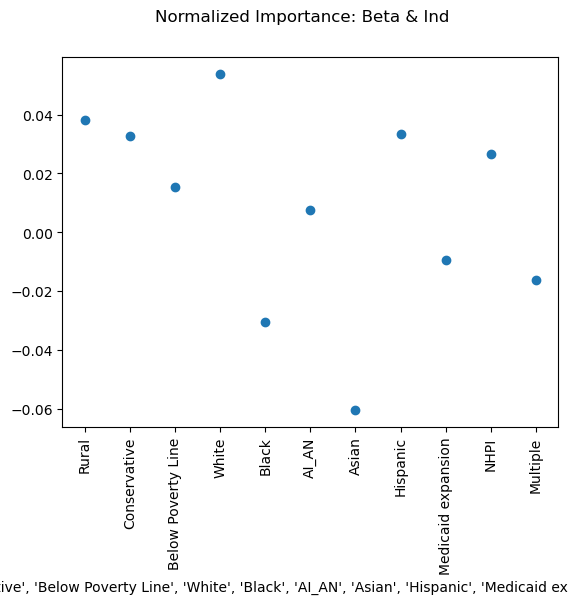

In [87]:
x_labels_tpe = list(df_variables_final.columns)

# plot_importance(beta_raw, x_labels, importance_type="Beta Raw")
plot_importance(importance_1_tpe, x_labels_tpe, importance_type="Normalized Importance: Beta & Ind")

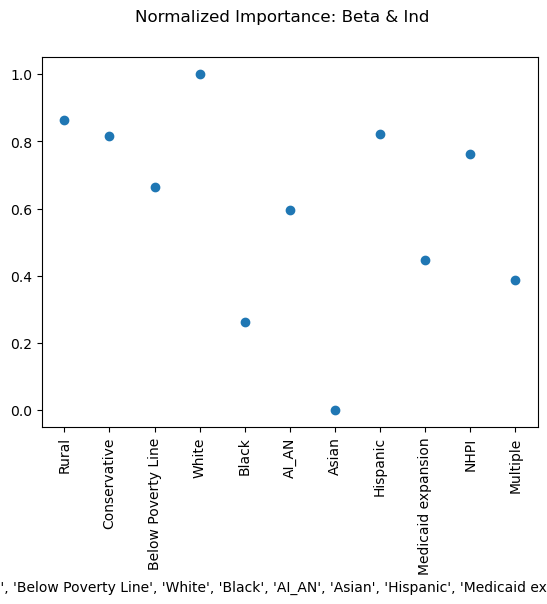

In [89]:
x_labels_tpe = list(df_variables_final.columns)

plot_importance(normalized_importance_1_tpe, x_labels_tpe, importance_type="Normalized Importance: Beta & Ind")

#### Calculate feature importance based on coefficient variance

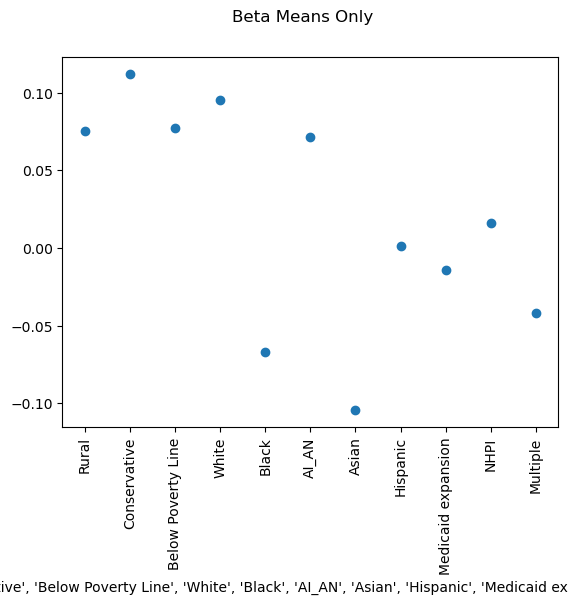

In [90]:
plot_importance(beta_means_tpe, x_labels_tpe, importance_type="Beta Means Only")

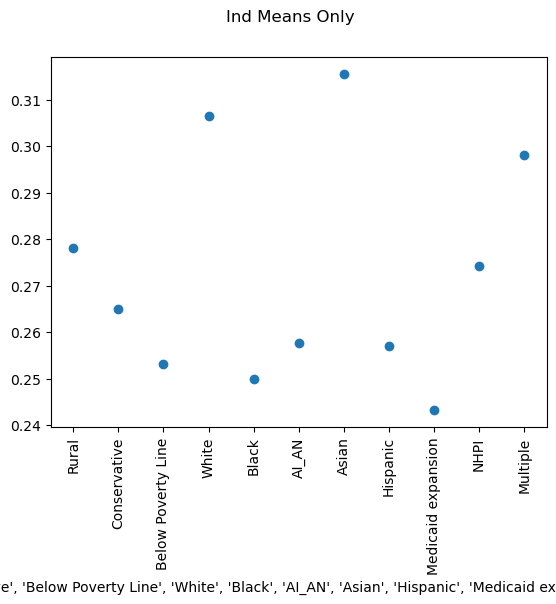

In [91]:
plot_importance(ind_means_tpe, x_labels_tpe, importance_type="Ind Means Only")

# Should work below here

In [92]:
beta_means_tpe = posterior_means_tpe.loc[
    posterior_means_tpe.index.str.startswith('beta') & ~posterior_means_tpe.index.str.startswith('beta_raw')
]

beta_raw_tpe = posterior_means_tpe.loc[
    posterior_means_tpe.index.str.startswith('beta_raw')
]

beta_std_tpe = posterior_std_tpe.loc[
    posterior_std_tpe.index.str.startswith('beta') & ~posterior_std_tpe.index.str.startswith('beta_raw')
]

ind_means_tpe = posterior_means_tpe.loc[posterior_means_tpe.index.str.startswith('ind')]

In [107]:
beta_means_qmc = posterior_means_qmc.loc[
    posterior_means_qmc.index.str.startswith('beta') & ~posterior_means_qmc.index.str.startswith('beta_raw')
]

beta_raw_qmc = posterior_means_qmc.loc[
    posterior_means_qmc.index.str.startswith('beta_raw')
]

beta_std_qmc = posterior_std_qmc.loc[
    posterior_std_qmc.index.str.startswith('beta') & ~posterior_std_qmc.index.str.startswith('beta_raw')
]

ind_means_qmc = posterior_means_qmc.loc[posterior_means_qmc.index.str.startswith('ind')]

x_labels_qmc = list(df_variables_final.columns)


In [93]:
importance_3_tpe = np.multiply(ind_means_tpe.values.flatten(), beta_raw_tpe.values.flatten())


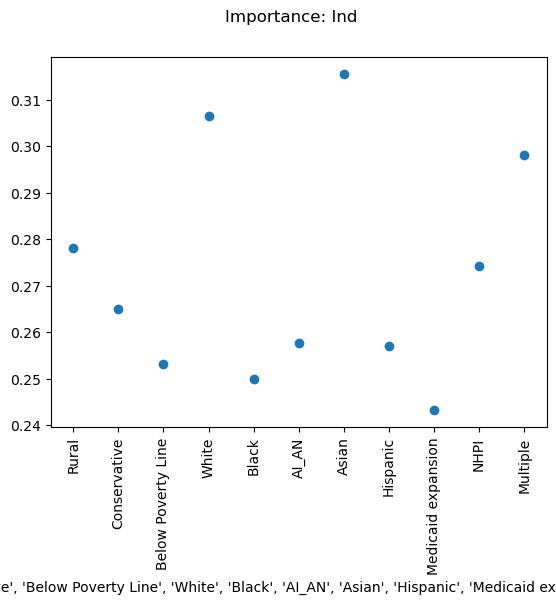

In [94]:
plot_importance(ind_means_tpe, x_labels_tpe, importance_type="Importance: Ind")

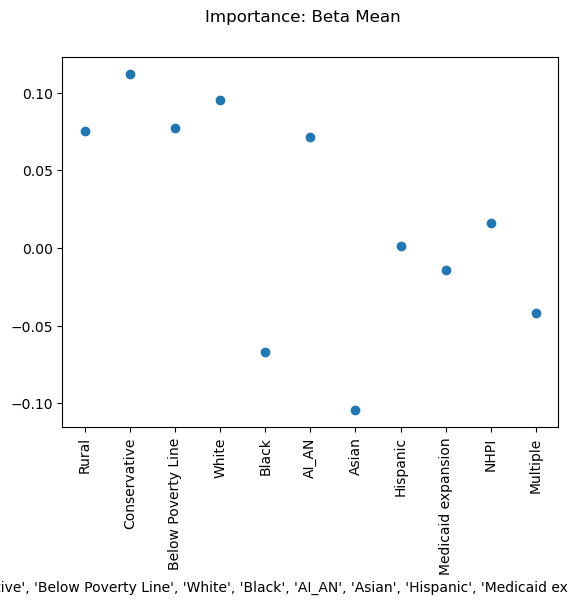

In [96]:
plot_importance(beta_means_tpe, x_labels_tpe, importance_type="Importance: Beta Mean")

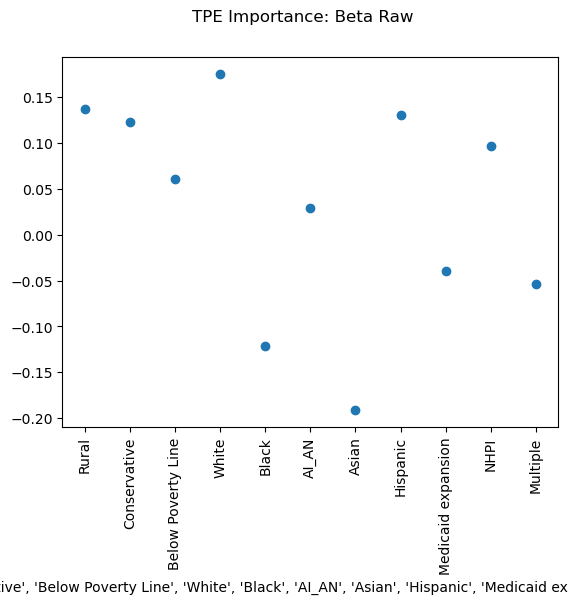

In [109]:
plot_importance(beta_raw_tpe, x_labels_tpe, importance_type="TPE Importance: Beta Raw")

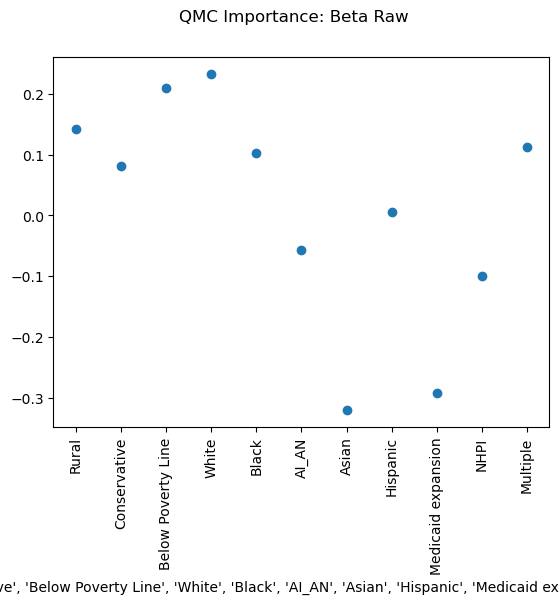

In [110]:
plot_importance(beta_raw_qmc, x_labels_qmc, importance_type="QMC Importance: Beta Raw")

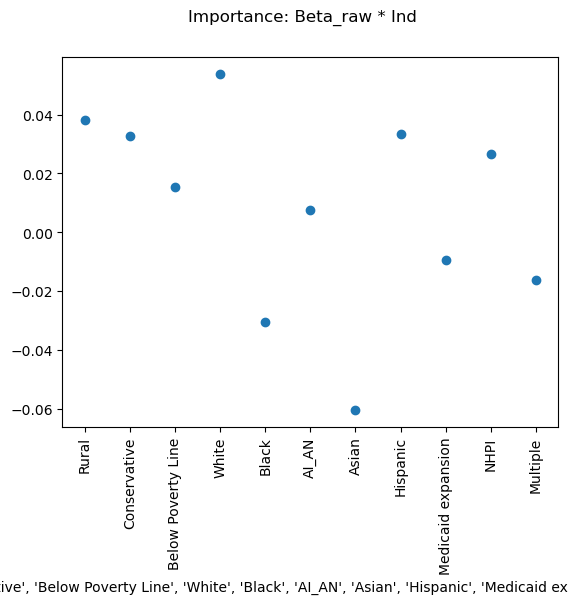

In [98]:
plot_importance(importance_3_tpe, x_labels_tpe, importance_type="Importance: Beta_raw * Ind")

In [179]:
# beta_means_new = beta_means.drop('beta[17]')
# beta_means_new_tpe = beta_means_new_tpe.drop('beta[0]')

NameError: name 'beta_means_new' is not defined

In [ ]:
# ind_means_new = ind_means.drop('ind[17]')
ind_means_new = ind_means_new.drop('ind[0]')

In [ ]:
import_new =  np.multiply(beta_means_new.values.flatten(), ind_means_new.values.flatten())

In [ ]:
new_labels = [item for item in x_labels if item != 'Medicaid expansion']
new_labels = [item for item in new_labels if item != 'Rural']

In [ ]:
plot_importance(import_new, new_labels, importance_type="Importance")

In [ ]:
plot_importance(beta_means, x_labels, importance_type="Beta Means")